In [82]:
# from keras.applications import mobilenet
from keras import layers , losses , optimizers , models ,initializers
from keras import backend as K
import numpy as np
from functools import *
from matplotlib import pyplot as plt
import cv2
from sklearn.utils import shuffle
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
set_session(sess)


In [97]:
def ImgDisplay(img1,img2):
    
    
    img1 = np.reshape( img1, img1.shape[:2] )
    img2 = np.reshape( img2 , img2.shape[:2] )
    
    fig , ax = plt.subplots(1,2 , figsize=(8,4))
    ax[0].imshow(img1 , cmap = 'gray')
    ax[1].imshow(img2 , cmap = 'gray')
    plt.show()

In [2]:
class SimpleModel:
    def __init__(self):
        self.l1 = layers.Conv2D(64 , (3,3) , activation = 'elu' , padding = 'same' , kernel_initializer=initializers.he_normal())
        self.l2 = layers.MaxPooling2D((2,2))
        self.l3 = layers.BatchNormalization()
        self.l4 = layers.Conv2D(32 , (3,3) , activation = 'elu' , padding = 'same', kernel_initializer=initializers.he_normal())
        self.l5 = layers.MaxPooling2D((2,2))
        self.l6 = layers.BatchNormalization()
        #self.l7 = layers.Flatten()
        #self.l8 = layers.Dense(32 , activation = 'relu' )
        self.SetLayerList()
        
    def SetLayerList(self):
        self.layers = [ x[-1] for x in self.__dict__.items()]
        
    def Build(self,input):
        alllist = [input ] + self.layers
        net = reduce(lambda f,s : s(f),alllist)
        return net

#### Load Jason , Create Image data

In [3]:
import json
samepath = "same.json"
diffpath = "diff.json"

In [4]:
samedict = None 
diffdata = None

with open(samepath , 'r') as f:
    samedict = json.load(f)
with open(diffpath , 'r') as f:
    diffdata = json.load(f)

In [5]:
samedata = samedict['0'] + samedict['1'] + samedict['2'] 
samelabel = np.zeros(len(samedata)).tolist()
difflabel = np.ones(len(diffdata)).tolist()

datas = samedata + diffdata
labels = samelabel + difflabel 

print('datas len = {} , labels len = {}'.format(len(datas) , len(labels)))

xs = np.asarray(list(map(lambda x : [cv2.imread(x[0],0) ,cv2.imread(x[1],0)], datas)))

datas len = 1770 , labels len = 1770


In [84]:
xs_reszied = np.asarray(list(map(lambda x : [cv2.resize(x[0],(32,32)) ,cv2.resize(x[1],(32,32))], xs)))
#xs_input = np.asarray(list(map(lambda x : [np.expand_dims(x[0],-1) ,np.expand_dims(x[1],-1)], xs_reszied)))
xs0 = np.asarray( list(map(lambda x :  np.expand_dims(x[0],-1) , xs_reszied)))
xs1 = np.asarray( list(map(lambda x :  np.expand_dims(x[1],-1) , xs_reszied)))


xs0 ,xs1 , labels = shuffle(xs0,xs1,labels , random_state = 10)


** Build Model**

In [85]:
input_shape = xs0[0].shape
print('input shape : {}'.format(input_shape))

#input1 = layers.Input((32,32,1,))
#input2 = layers.Input((32,32,1,))

input1 = layers.Input(input_shape)
input2 = layers.Input(input_shape)



simplenet = SimpleModel()

input shape : (32, 32, 1)


In [86]:
encode1 = simplenet.Build(input1)
encode2 = simplenet.Build(input2)

x = layers.subtract([encode1 , encode2])
x = layers.Lambda(lambda x : K.abs(x))(x)

#x = layers.Lambda(lambda x : K.sum(x , axis = (-1)))(x)
#x = layers.Activation('sigmoid')(x)
x = layers.Flatten()(x)

prediction = layers.Dense(1,activation='sigmoid')(x)
#model = models.Model([input1,input2] , prediction)
model = models.Model([input1,input2] , prediction)


In [87]:
model.compile(loss = losses.binary_crossentropy , optimizer=optimizers.Adam(0.00006) , metrics=['acc'])

**Train Model**

In [88]:
print(xs0.shape)
print(type(xs0))
print(type(xs0[0]))
print(type(xs0[0][0]))
print(type(xs0[0][0][0][0]))

(1770, 32, 32, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.uint8'>


In [89]:
hist = model.fit([xs0,xs1] , labels , batch_size=64 ,validation_split=0.1, epochs=30 , verbose = 1)

Train on 1593 samples, validate on 177 samples
Epoch 1/30
1593/1593 [==============================] - 1s 801us/step - loss: 0.7819 - acc: 0.6277 - val_loss: 0.5696 - val_acc: 0.7119
Epoch 2/30
1593/1593 [==============================] - 0s 208us/step - loss: 0.6241 - acc: 0.6893 - val_loss: 0.4780 - val_acc: 0.8023
Epoch 3/30
1593/1593 [==============================] - 0s 200us/step - loss: 0.5369 - acc: 0.7633 - val_loss: 0.4435 - val_acc: 0.8418
Epoch 4/30
1593/1593 [==============================] - 0s 207us/step - loss: 0.4884 - acc: 0.7979 - val_loss: 0.4209 - val_acc: 0.8531
Epoch 5/30
1593/1593 [==============================] - 0s 201us/step - loss: 0.4582 - acc: 0.8299 - val_loss: 0.4084 - val_acc: 0.8701
Epoch 6/30
1593/1593 [==============================] - 0s 192us/step - loss: 0.4373 - acc: 0.8412 - val_loss: 0.3990 - val_acc: 0.8983
Epoch 7/30
1593/1593 [==============================] - 0s 189us/step - loss: 0.4201 - acc: 0.8512 - val_loss: 0.3924 - val_acc: 0.8983
E

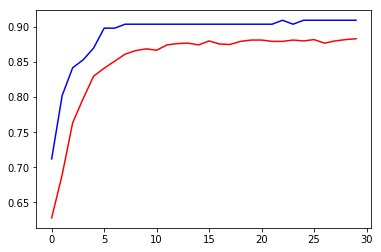

In [90]:
plt.plot(hist.history['acc'] , c = 'r')
plt.plot(hist.history['val_acc'] , c = 'b')
plt.show()

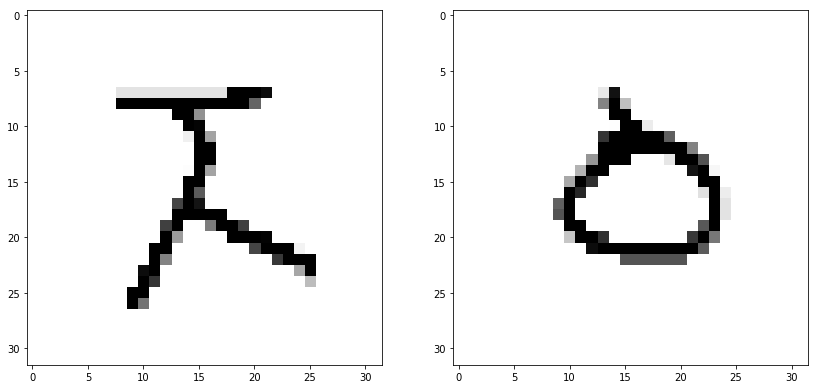

array([[0.95330584]], dtype=float32)

In [91]:
test1 = xs0[6]
test2 = xs1[1]

ImgDisplay(test1,test2)

t1 = np.asarray([test1])
t2 = np.asarray([test2])
res = model.predict([t1,t2])
res


[[0.9687695]] 0


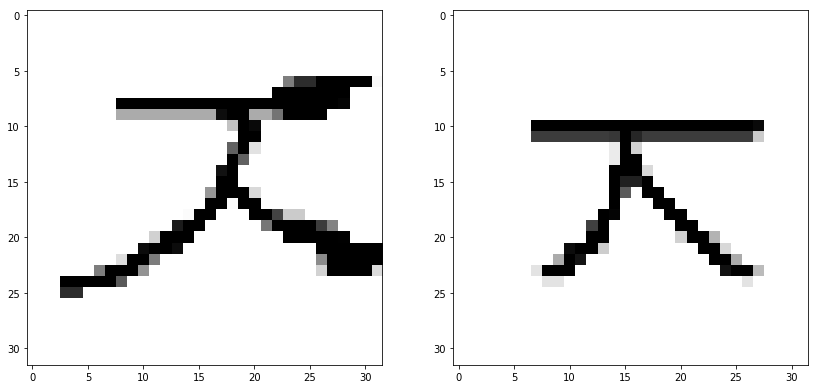

[[0.9687695]] 1


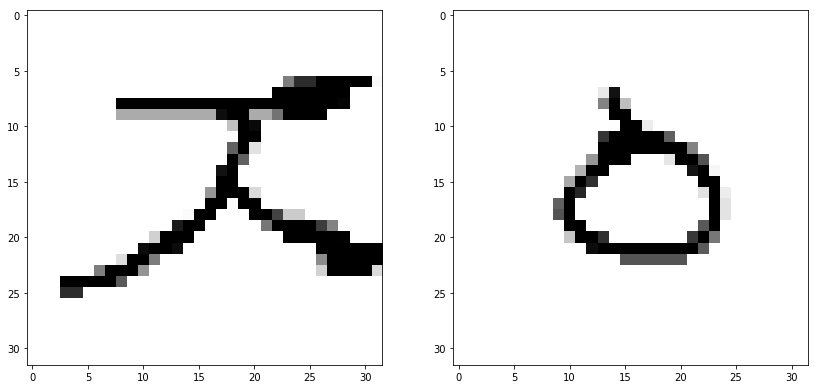

[[0.9687695]] 2


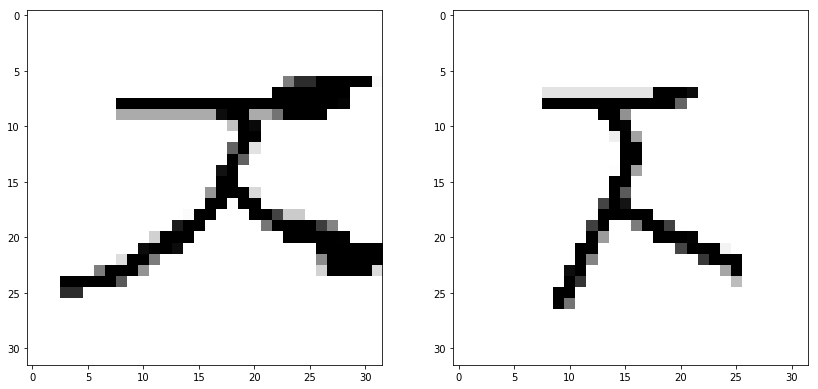

[[0.9687695]] 3


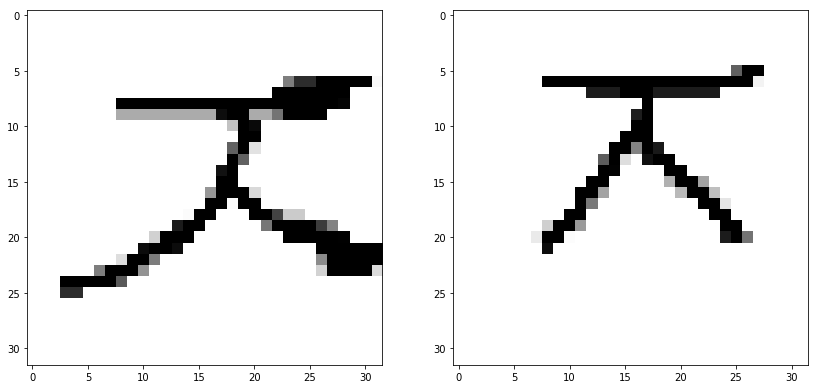

[[0.9687695]] 4


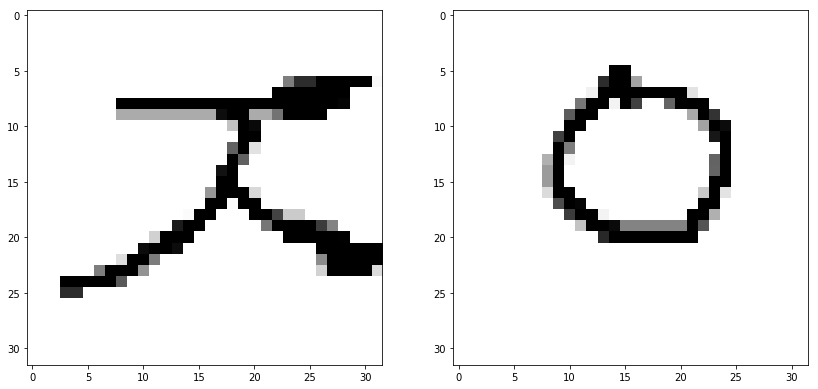

[[0.9687695]] 5


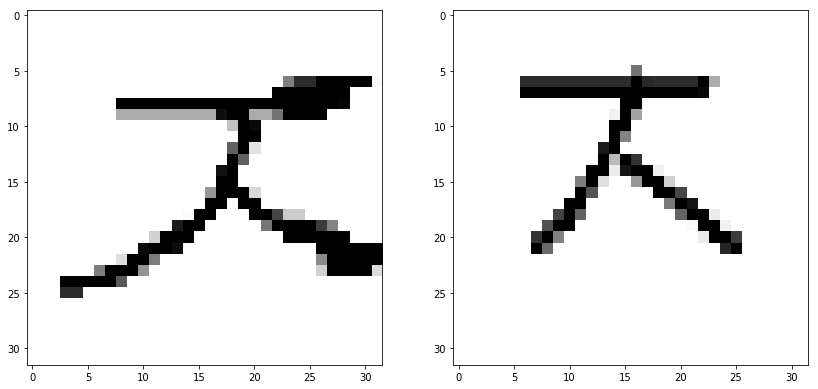

[[0.9687695]] 6


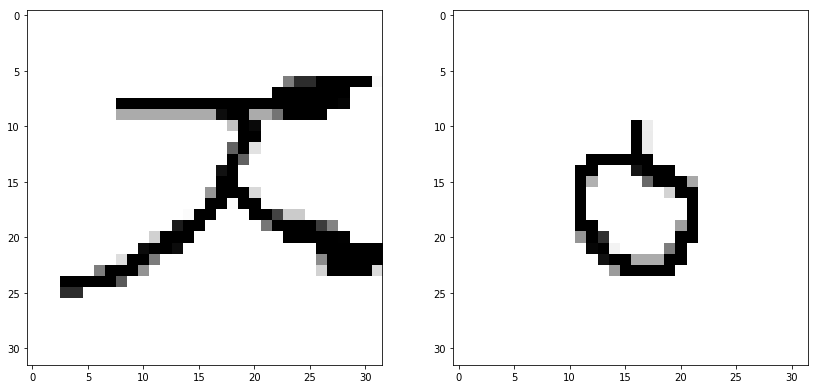

[[0.9687695]] 7


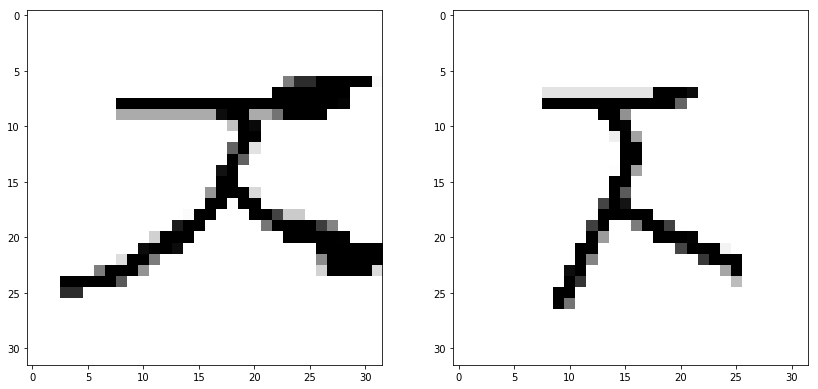

[[0.9687695]] 8


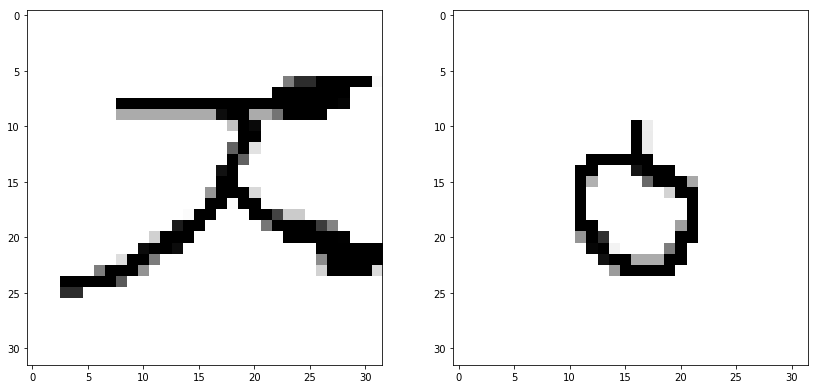

[[0.9687695]] 9


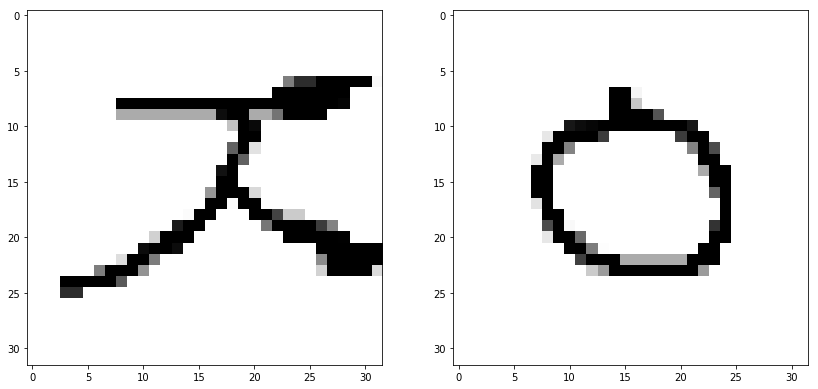

[[0.9687695]] 10


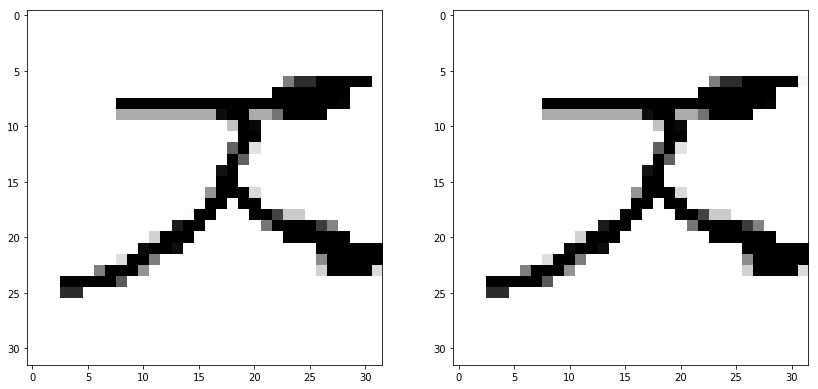

[[0.9687695]] 11


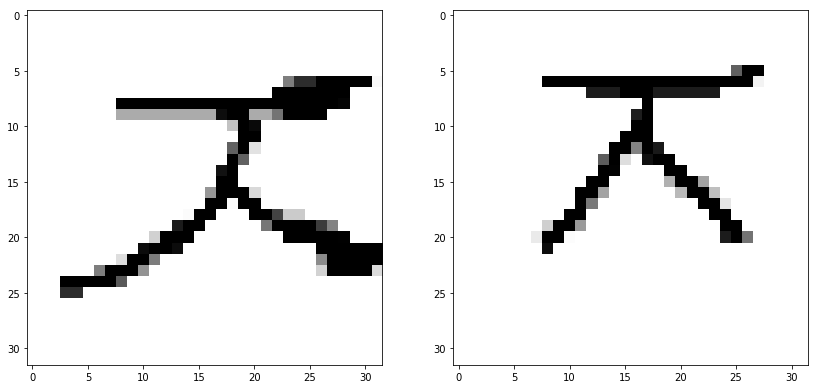

[[0.9687695]] 12


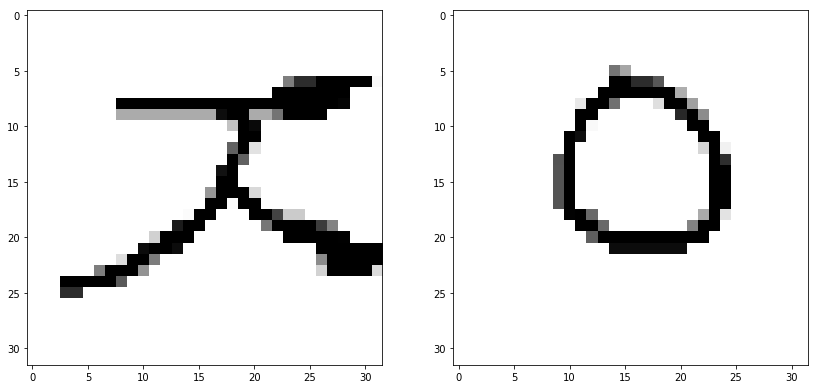

[[0.9687695]] 13


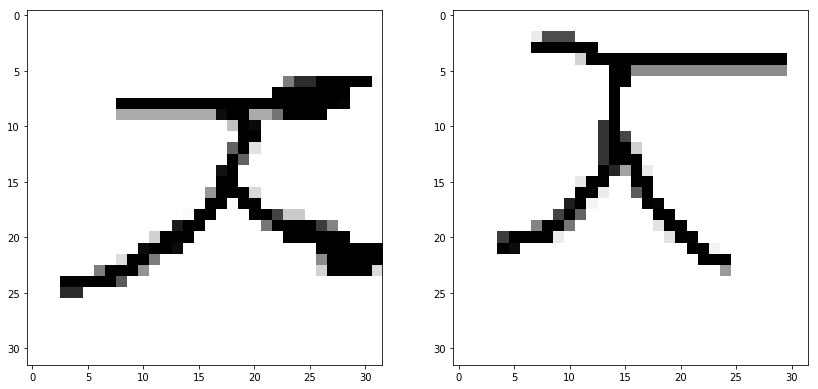

[[0.9687695]] 14


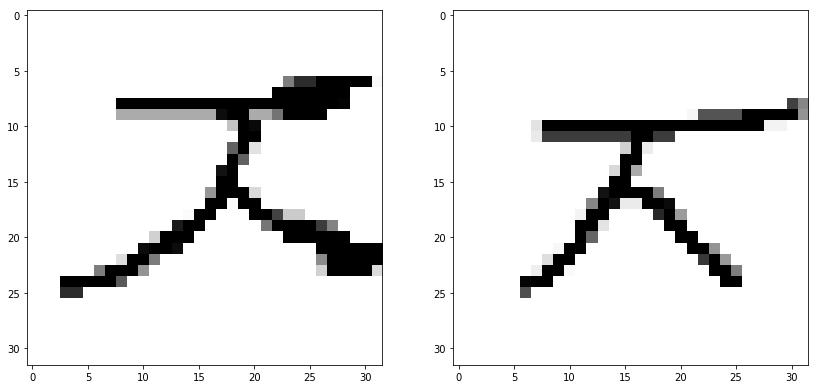

[[0.9687695]] 15


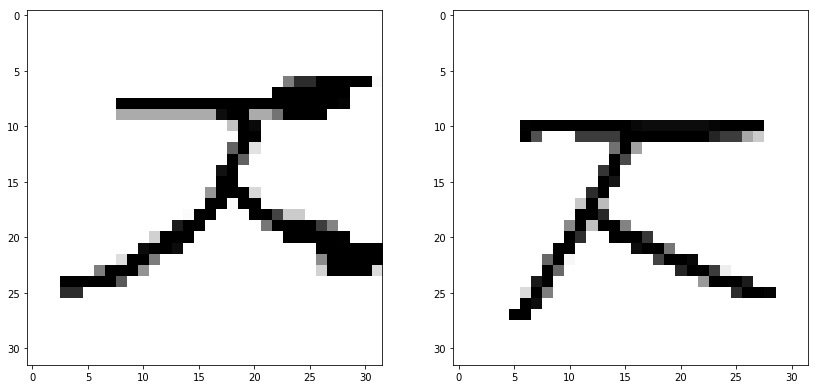

[[0.9687695]] 16


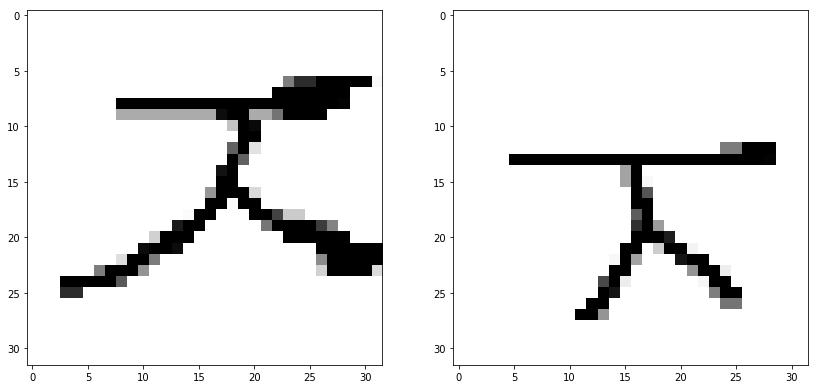

[[0.9687695]] 17


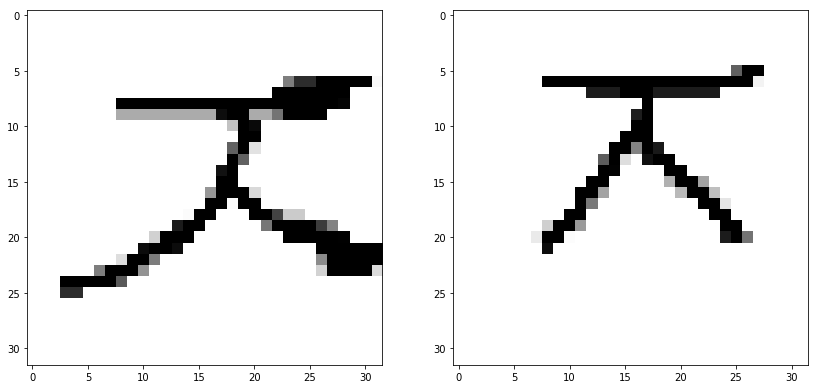

[[0.9687695]] 18


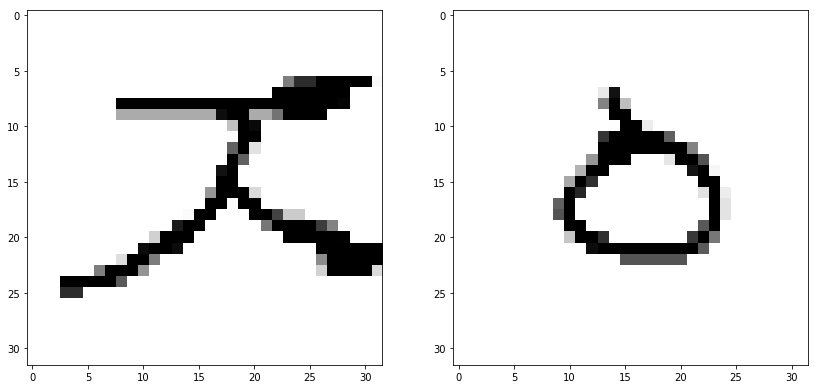

[[0.9687695]] 19


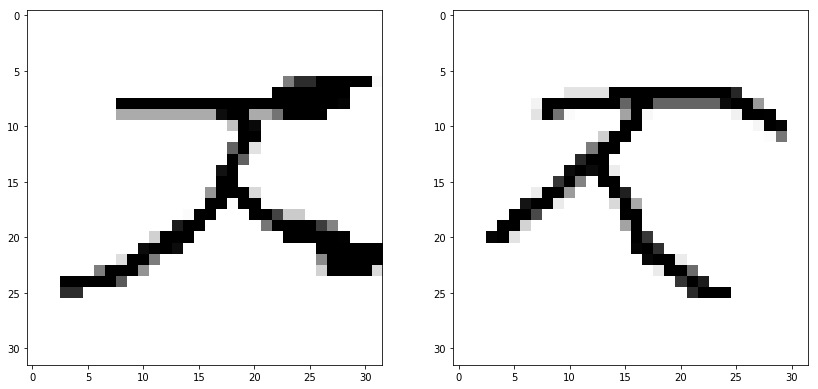

[[0.9687695]] 20


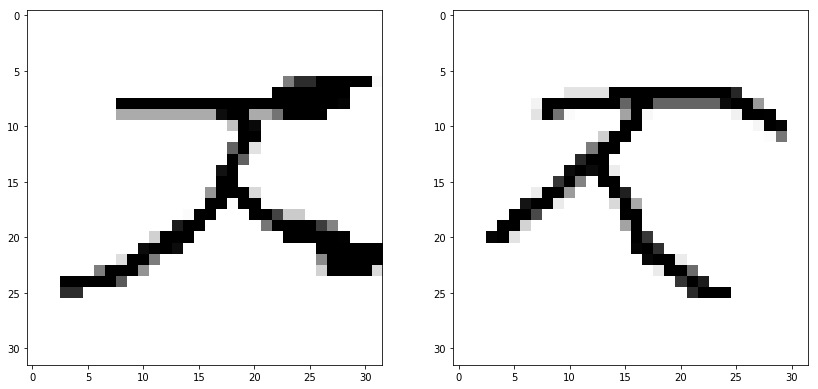

[[0.9687695]] 21


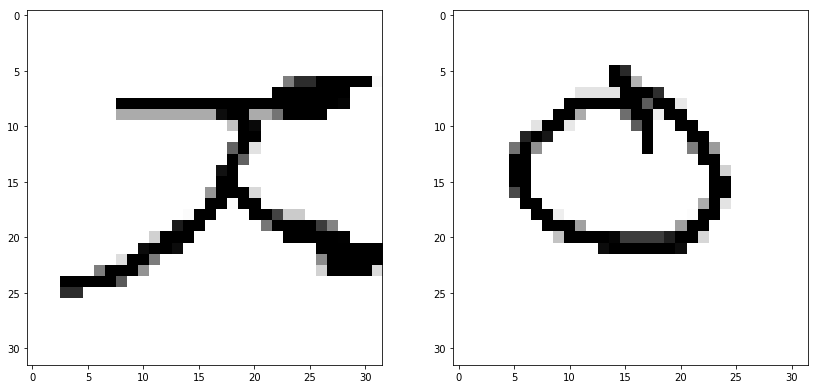

[[0.9687695]] 22


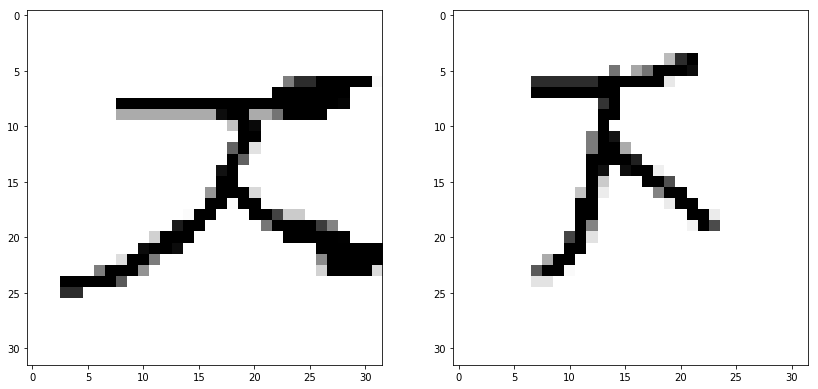

[[0.9687695]] 23


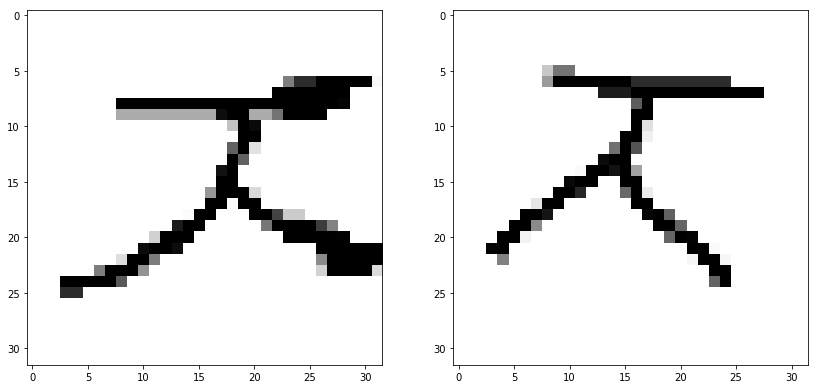

[[0.9687695]] 24


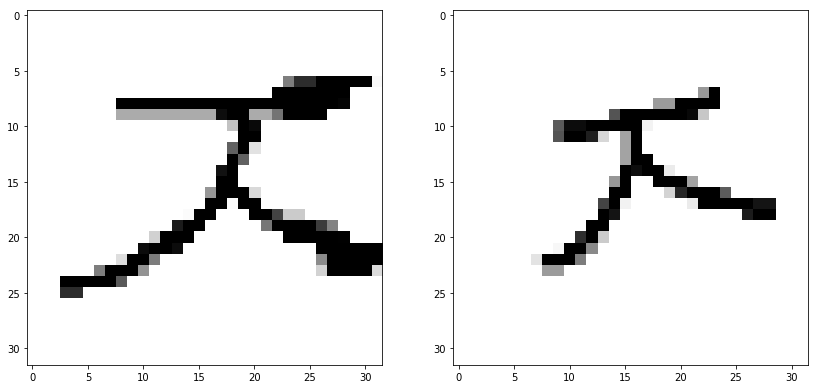

[[0.9687695]] 25


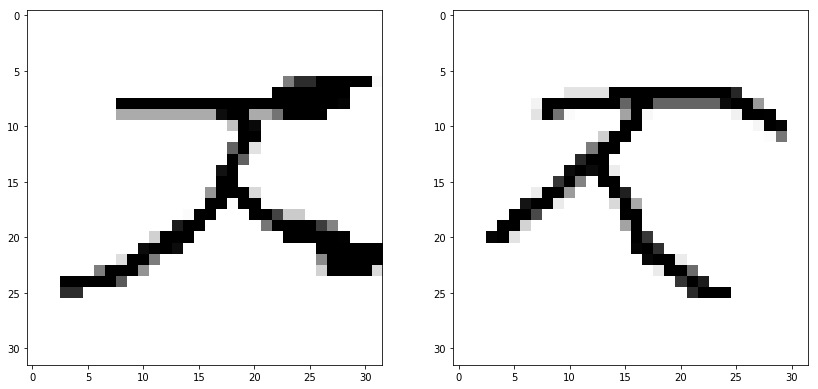

[[0.9687695]] 26


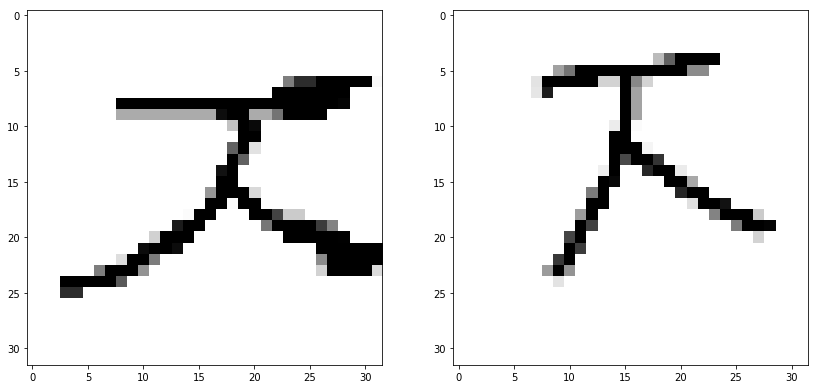

[[0.9687695]] 27


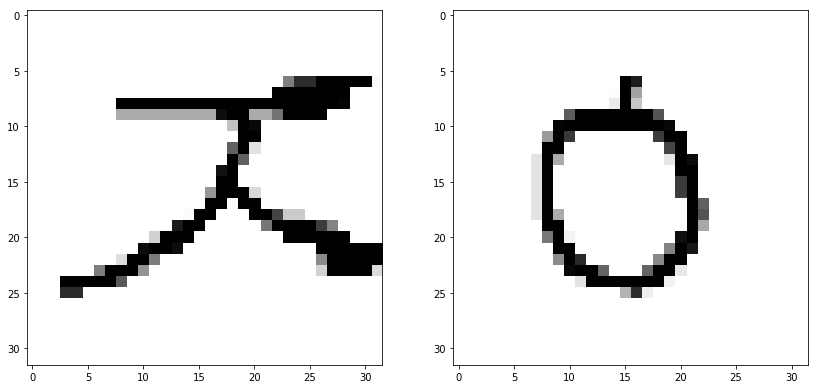

[[0.9687695]] 28


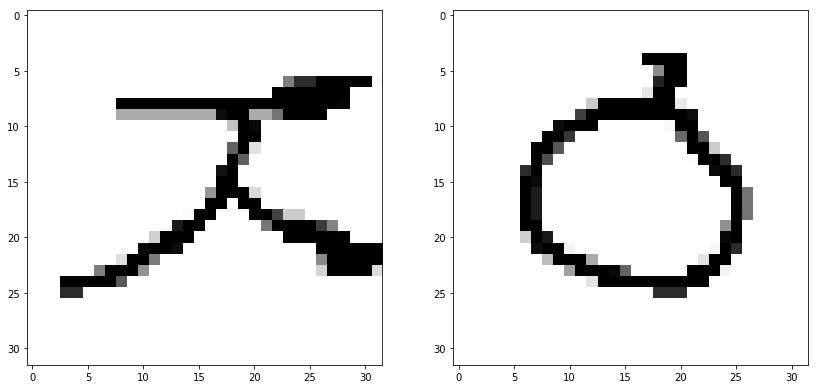

[[0.9687695]] 29


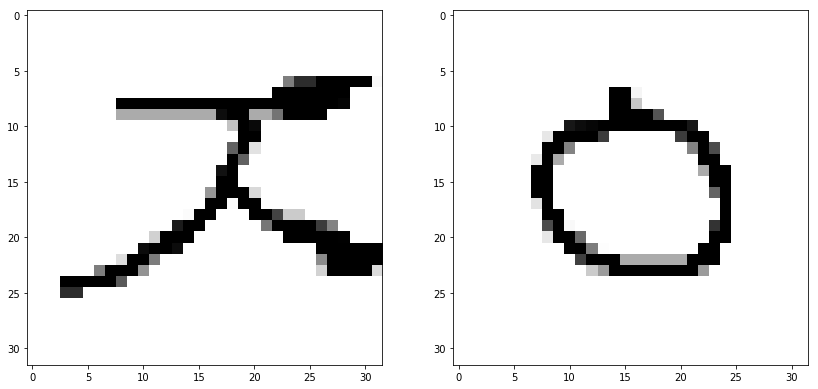

[[0.9687695]] 30


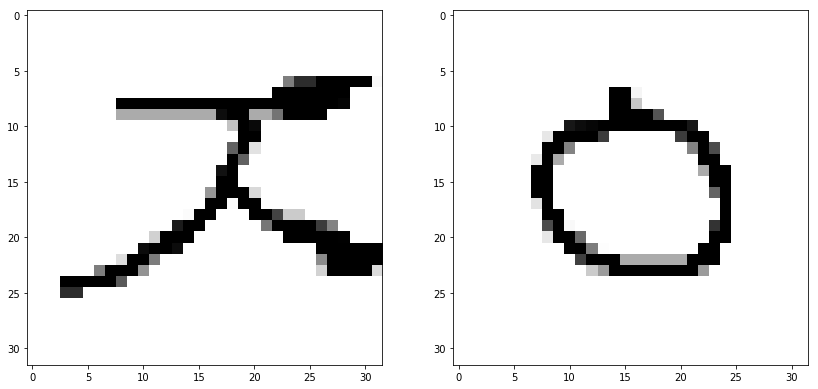

[[0.9687695]] 31


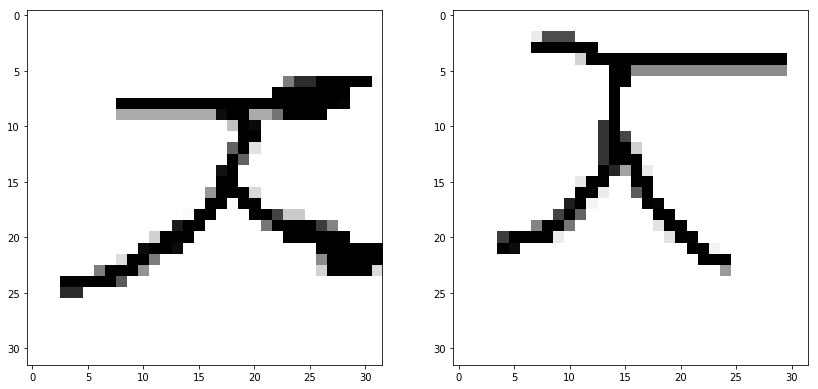

[[0.9687695]] 32


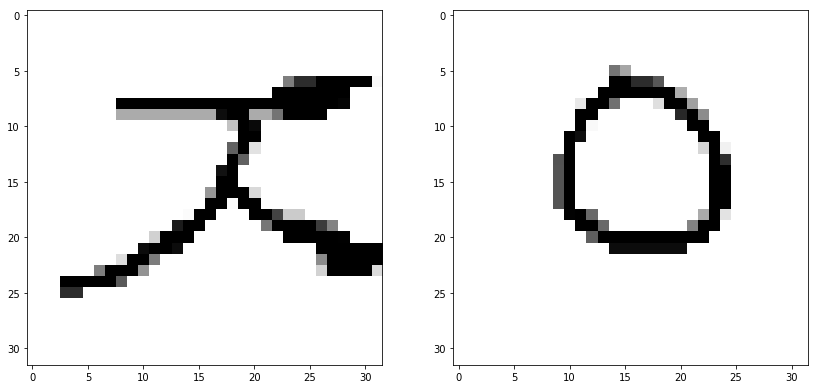

[[0.9687695]] 33


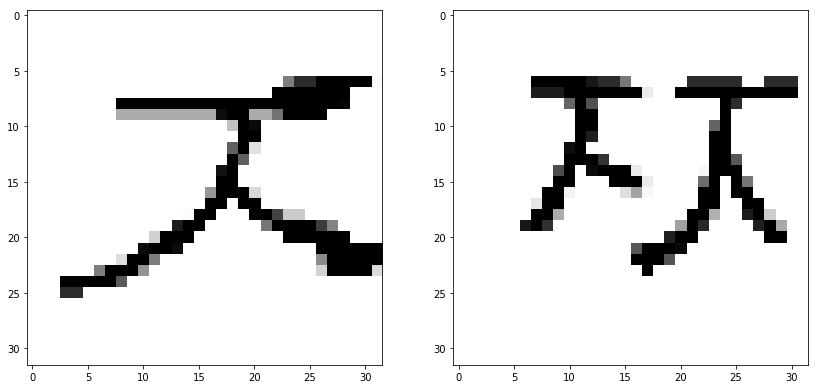

[[0.9687695]] 34


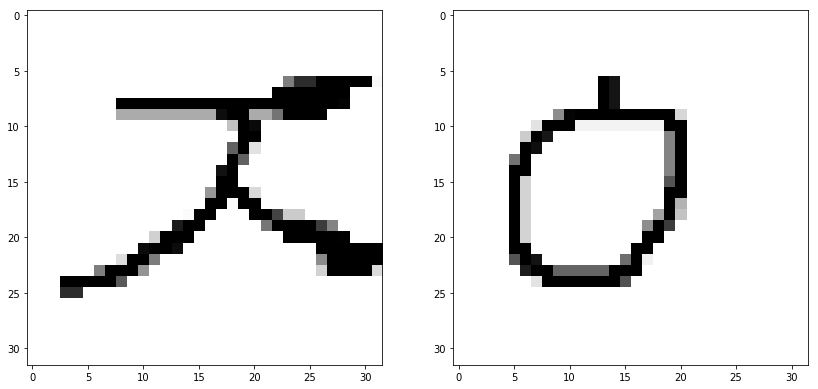

[[0.9687695]] 35


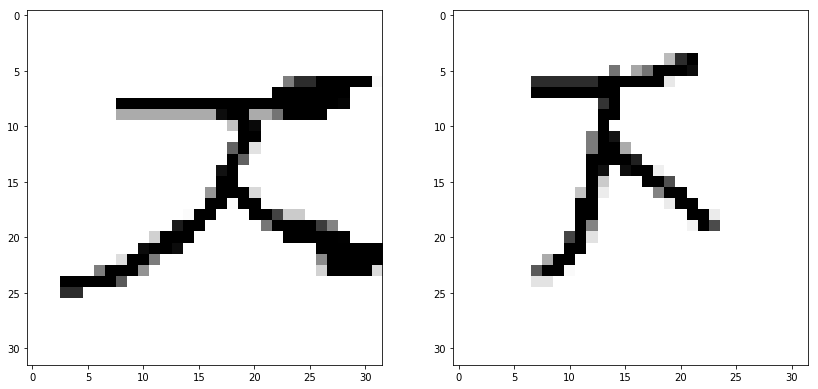

[[0.9687695]] 36


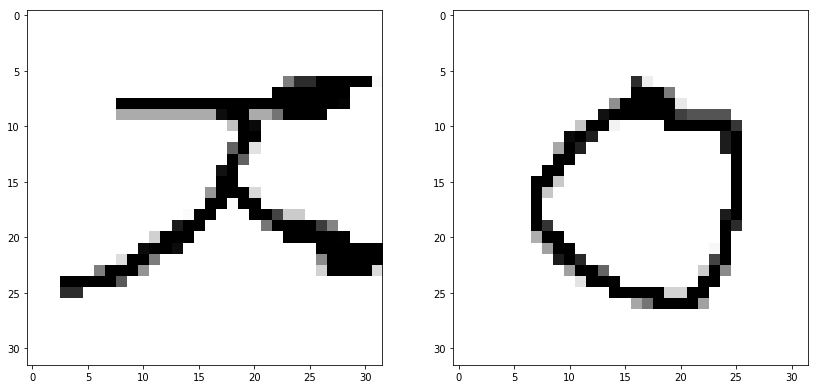

[[0.9687695]] 37


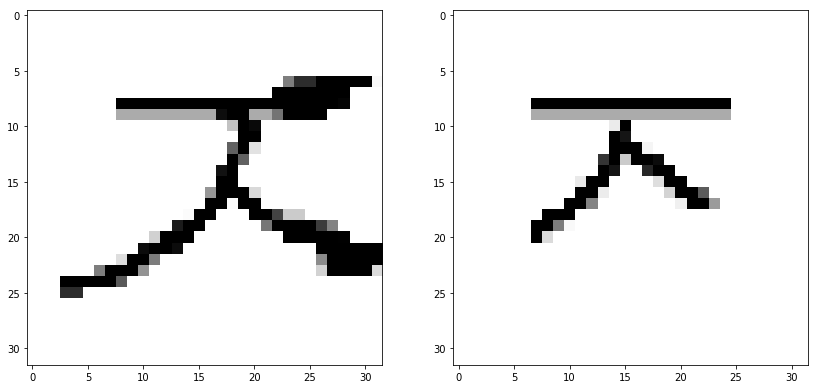

[[0.9687695]] 38


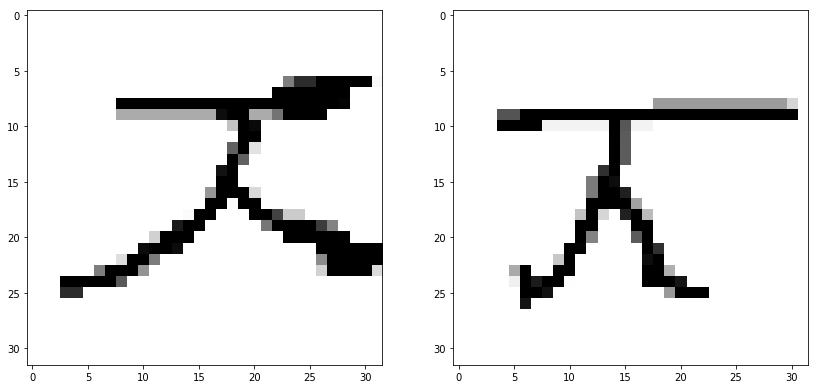

[[0.9687695]] 39


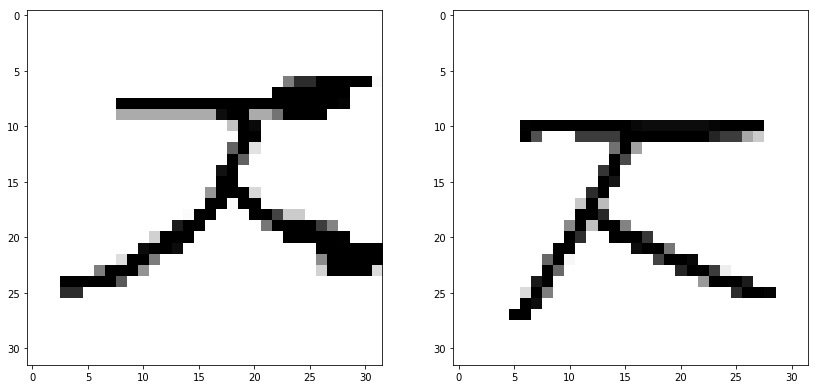

[[0.9687695]] 40


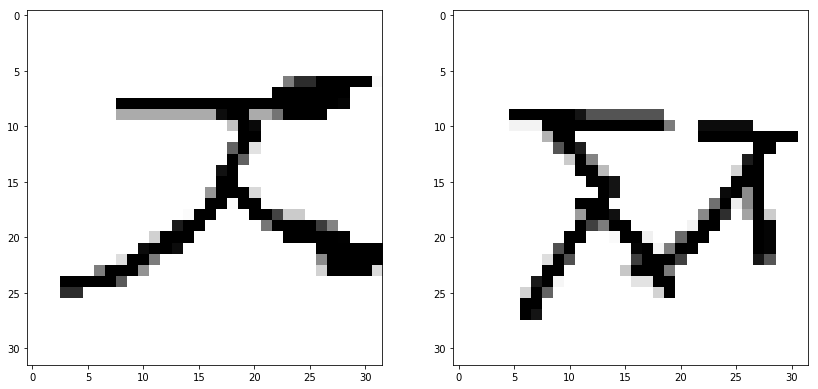

[[0.9687695]] 41


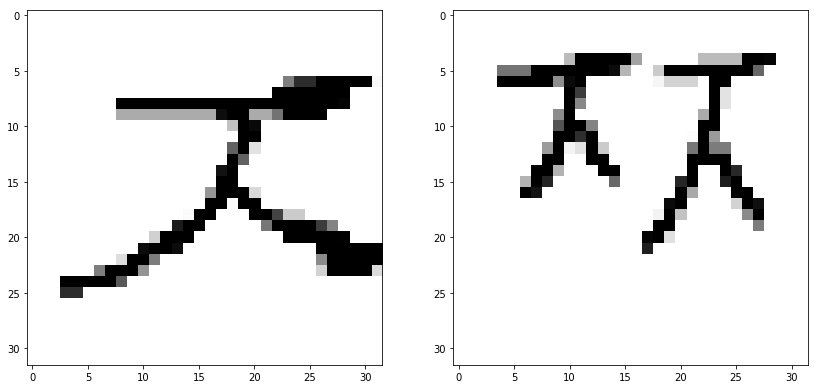

[[0.9687695]] 42


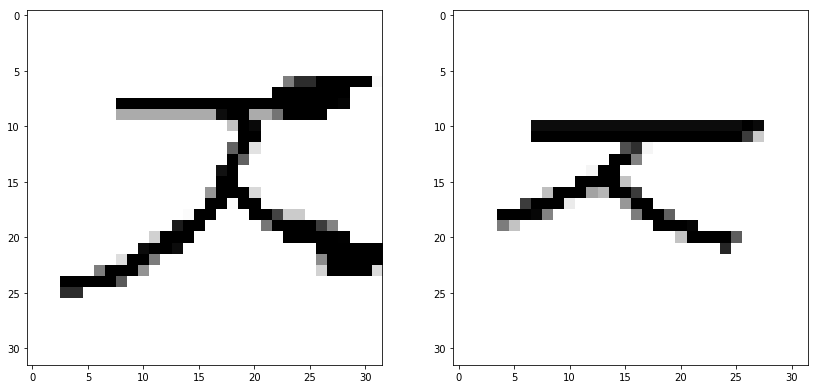

[[0.9687695]] 43


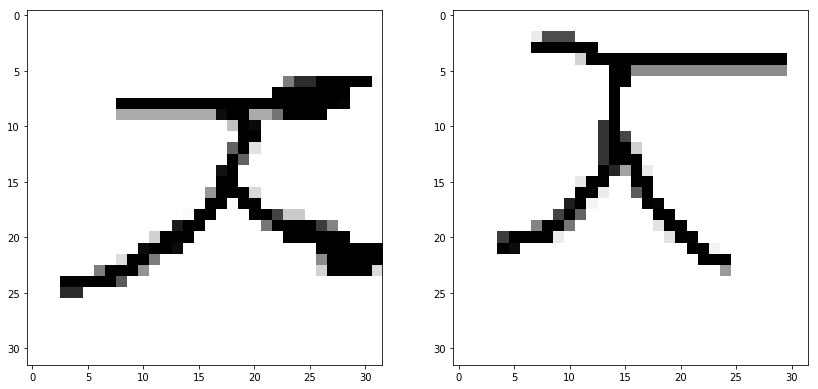

[[0.9687695]] 44


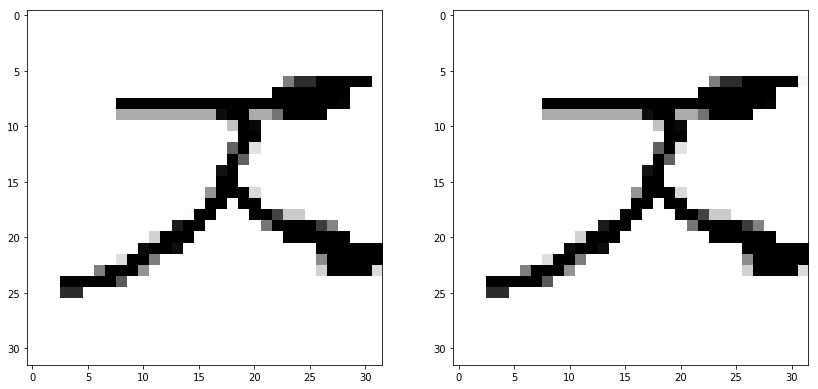

[[0.9687695]] 45


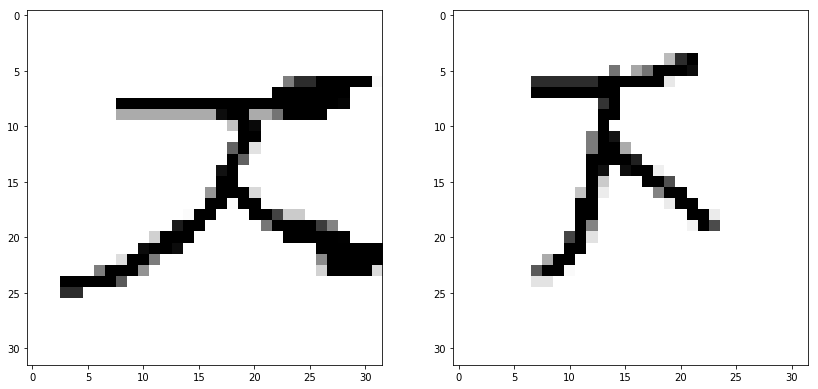

[[0.9687695]] 46


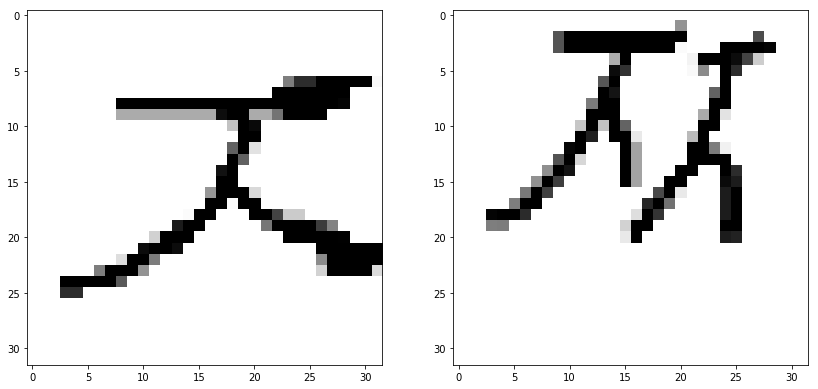

[[0.9687695]] 47


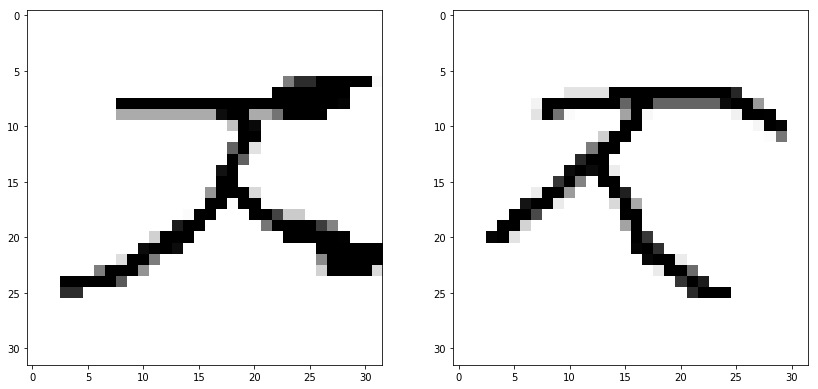

[[0.9687695]] 48


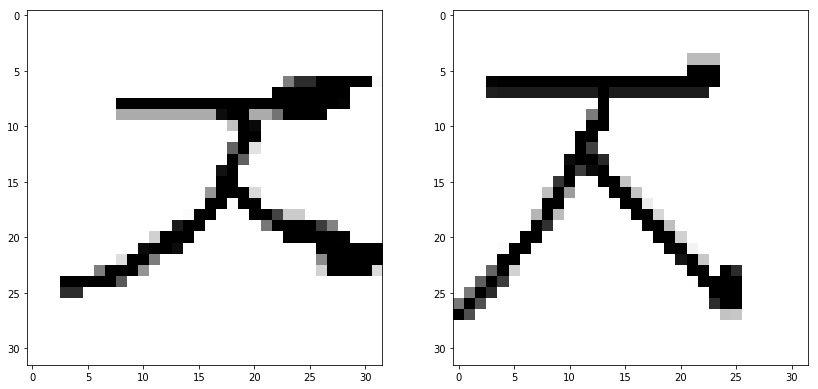

[[0.9687695]] 49


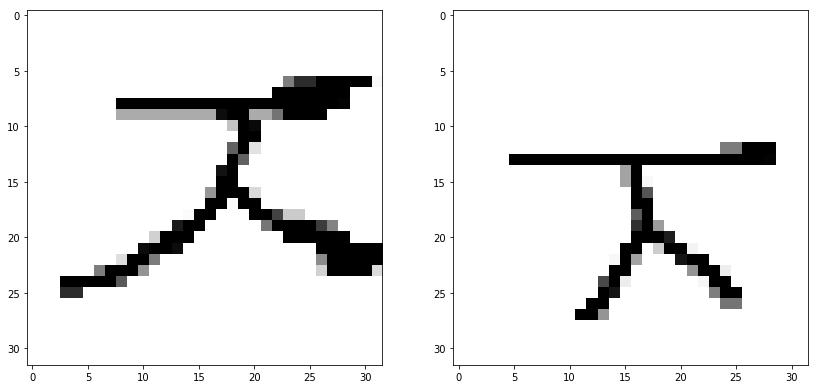

[[0.9687695]] 50


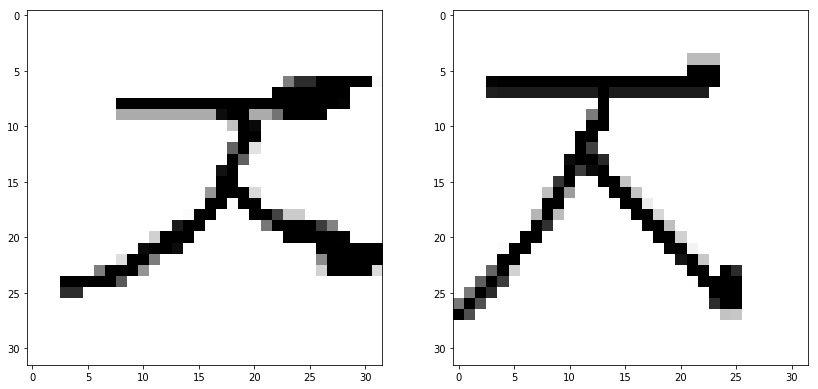

[[0.9687695]] 51


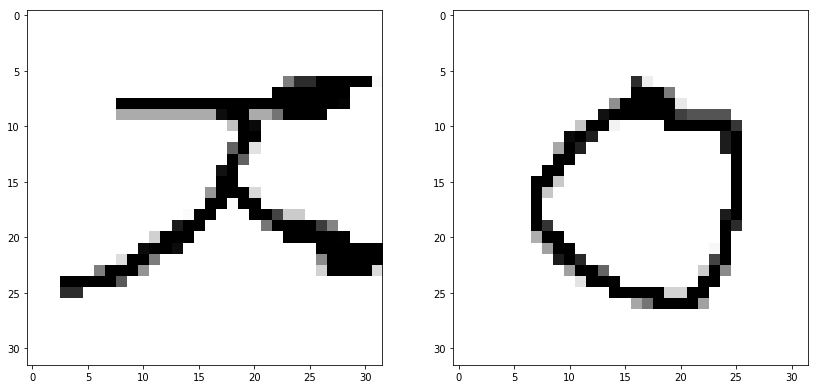

[[0.9687695]] 52


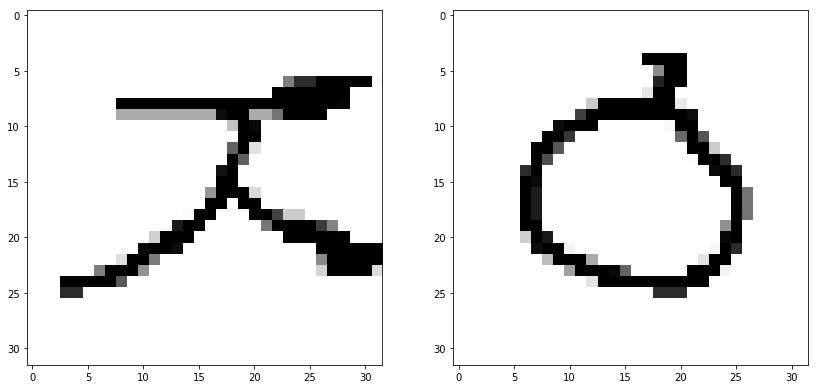

[[0.9687695]] 53


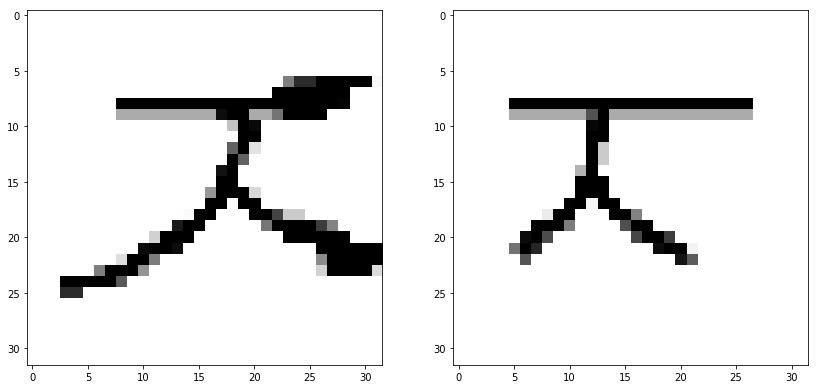

[[0.9687695]] 54


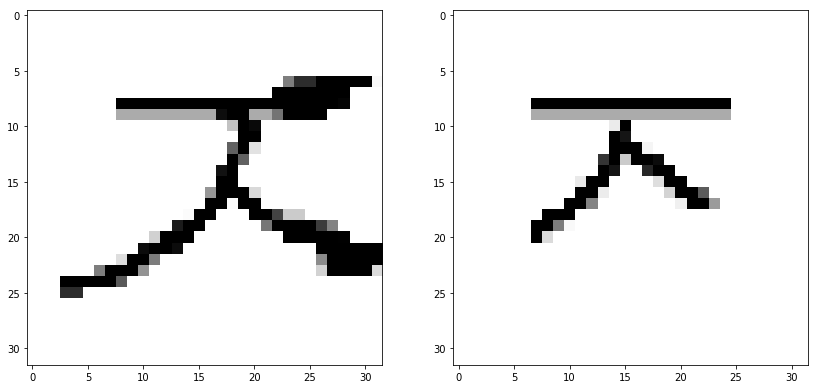

[[0.9687695]] 55


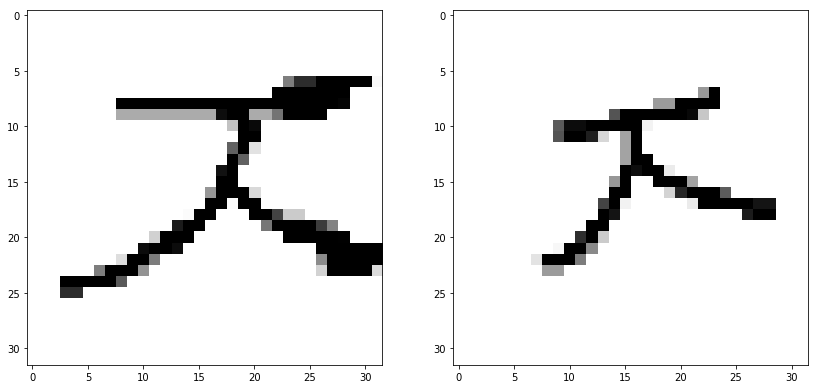

[[0.9687695]] 56


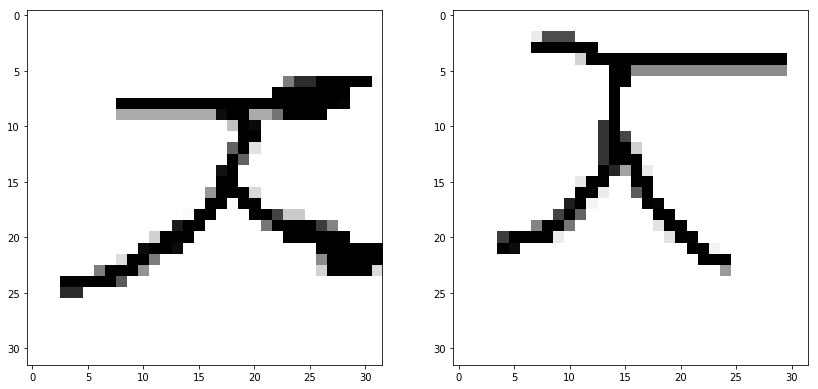

[[0.9687695]] 57


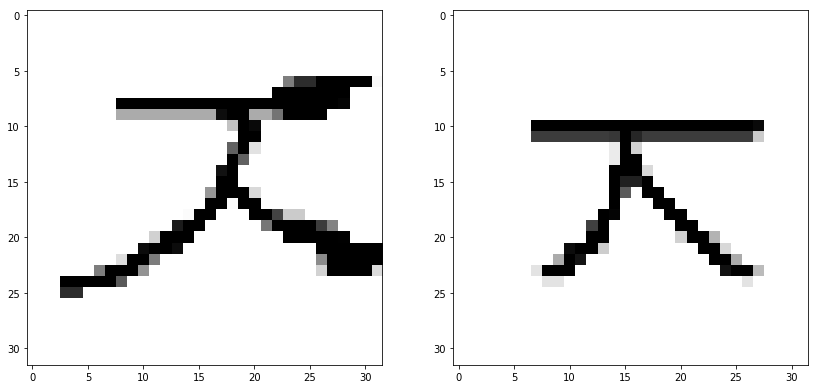

[[0.9687695]] 58


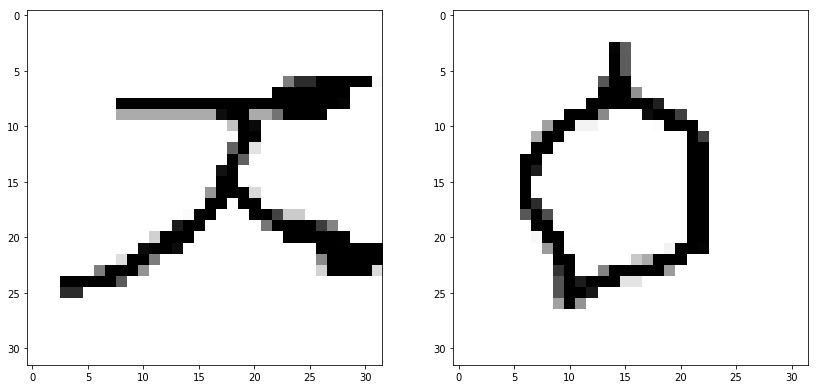

[[0.9687695]] 59


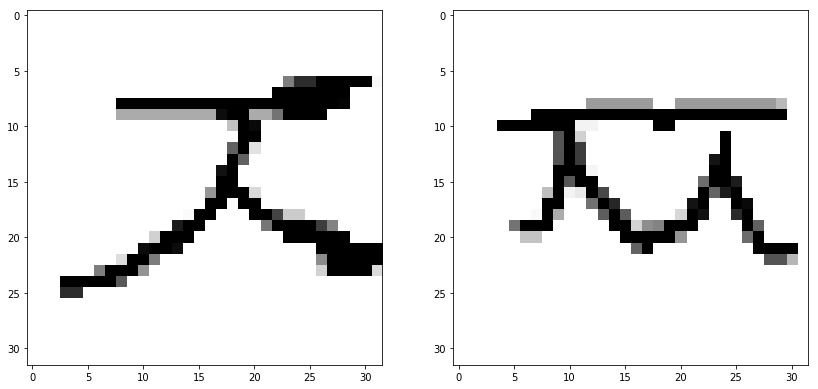

[[0.9687695]] 60


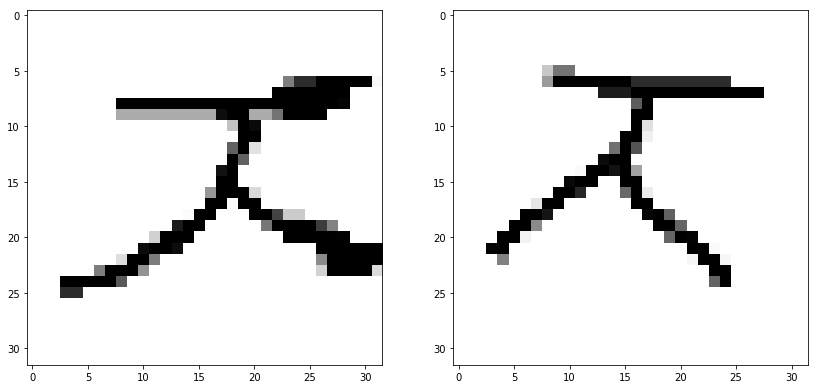

[[0.9687695]] 61


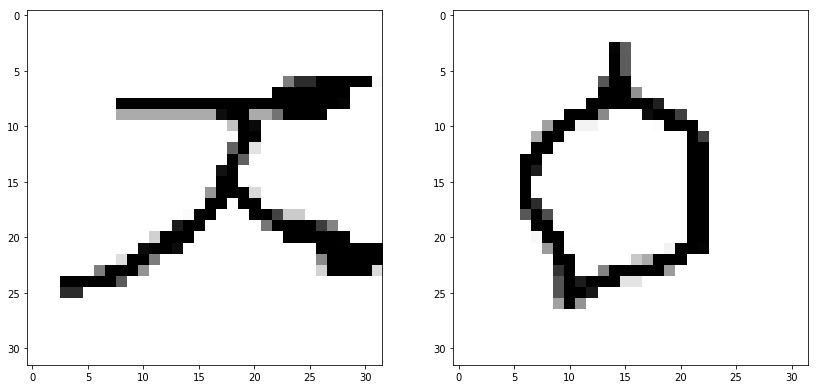

[[0.9687695]] 62


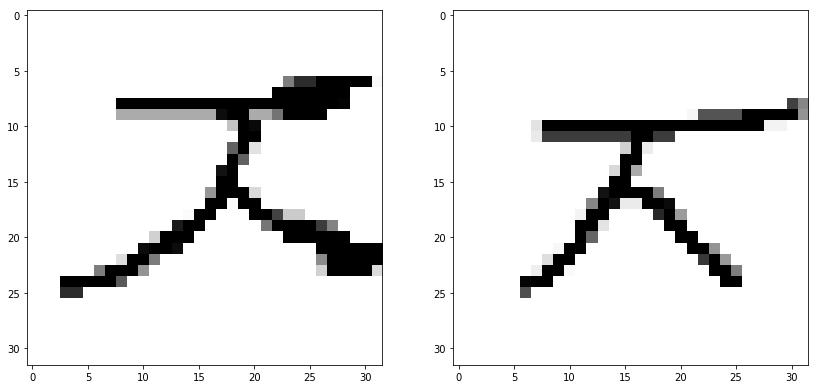

[[0.9687695]] 63


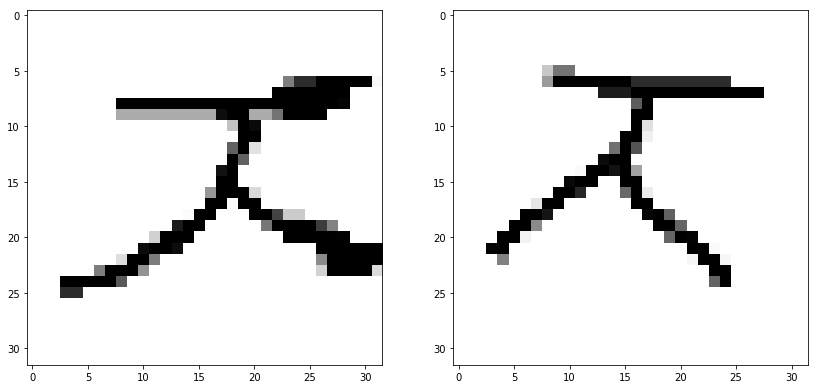

[[0.9687695]] 64


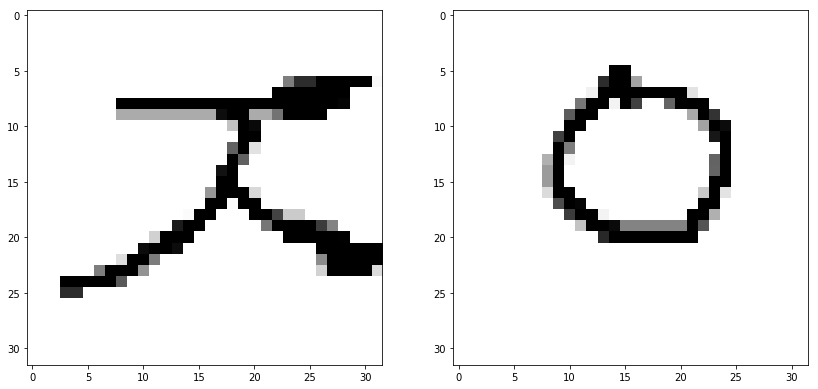

[[0.9687695]] 65


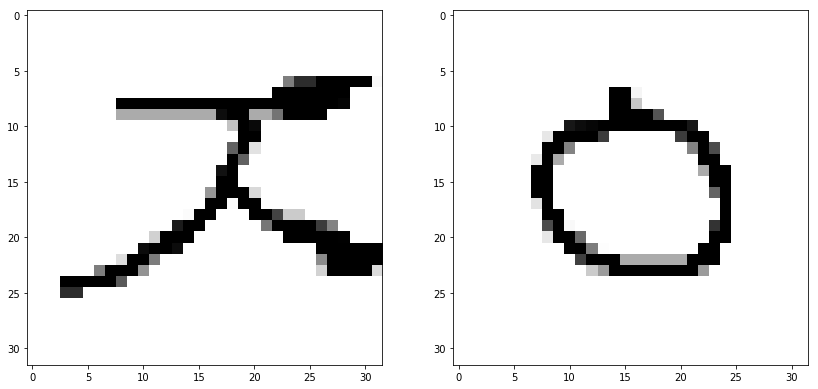

[[0.9687695]] 66


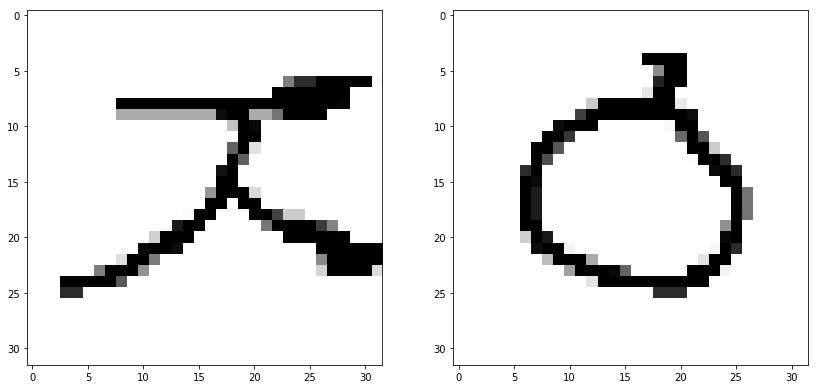

[[0.9687695]] 67


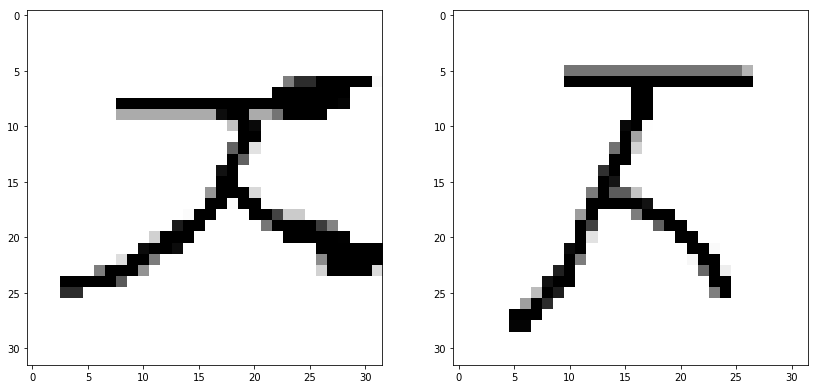

[[0.9687695]] 68


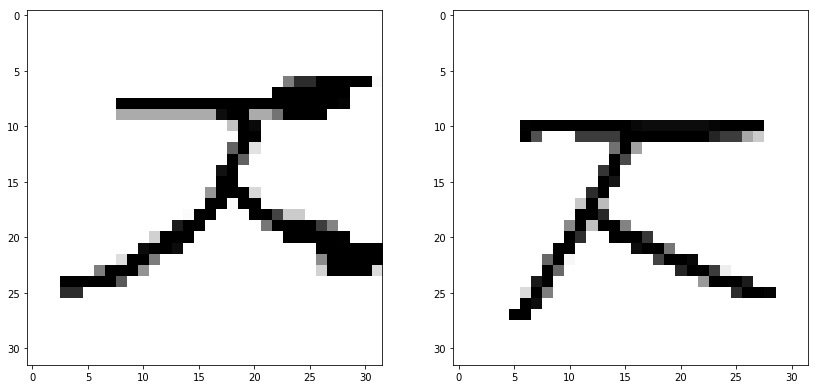

[[0.9687695]] 69


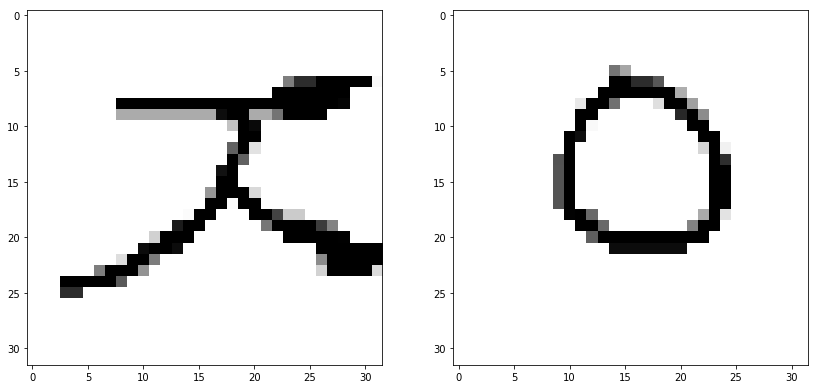

[[0.9687695]] 70


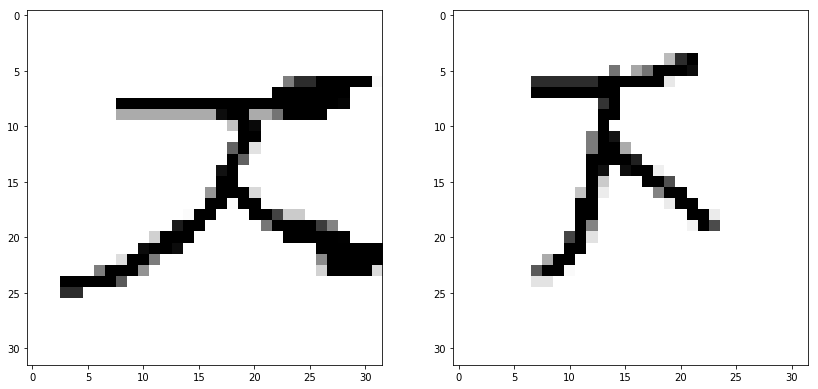

[[0.9687695]] 71


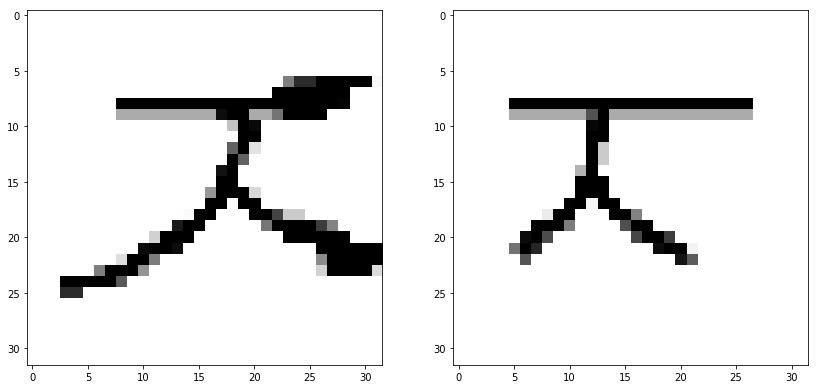

[[0.9687695]] 72


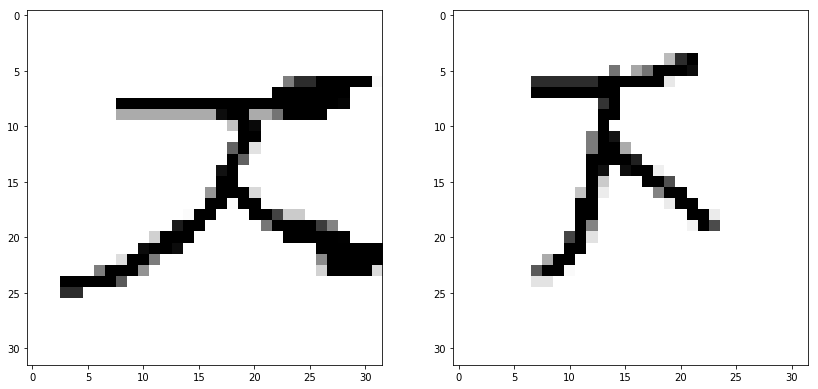

[[0.9687695]] 73


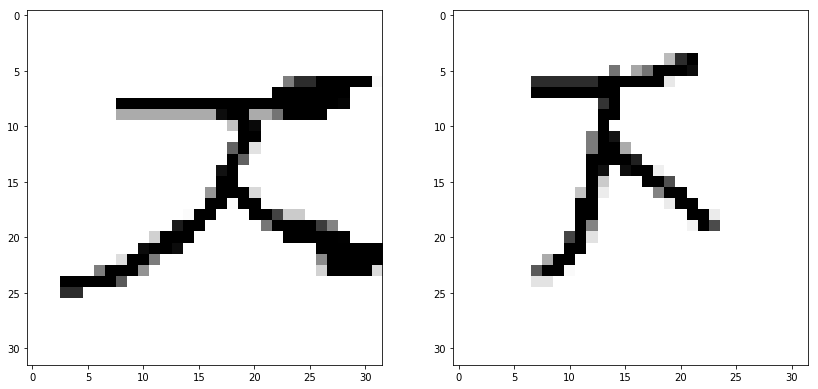

[[0.9687695]] 74


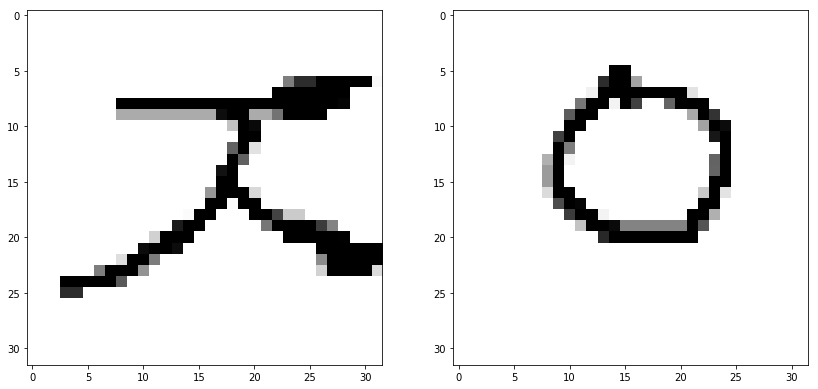

[[0.9687695]] 75


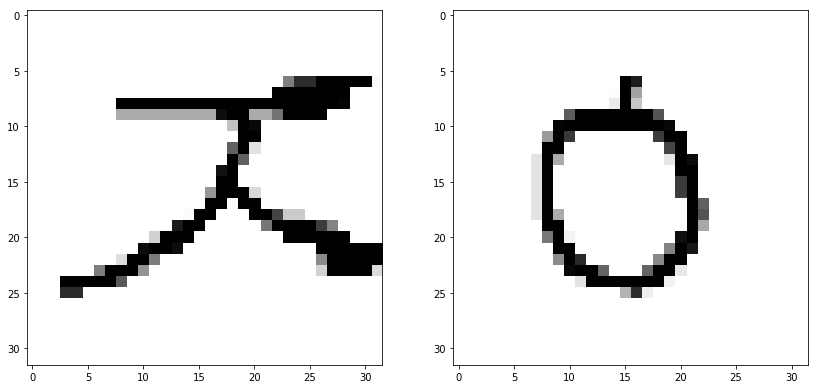

[[0.9687695]] 76


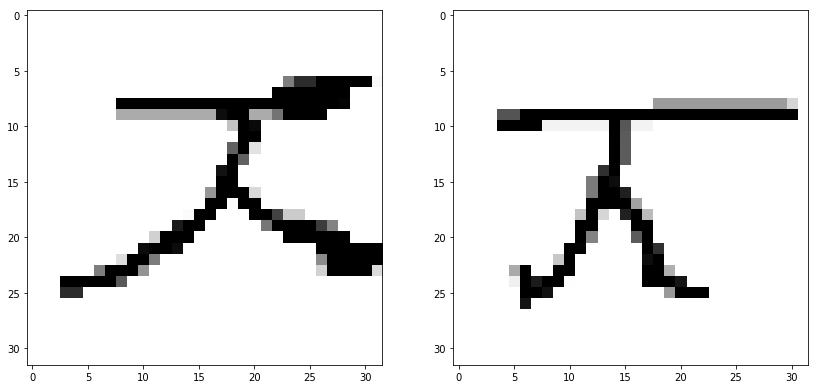

[[0.9687695]] 77


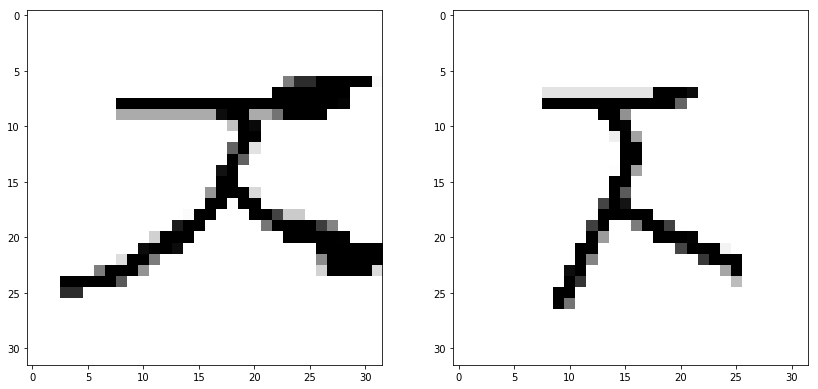

[[0.9687695]] 78


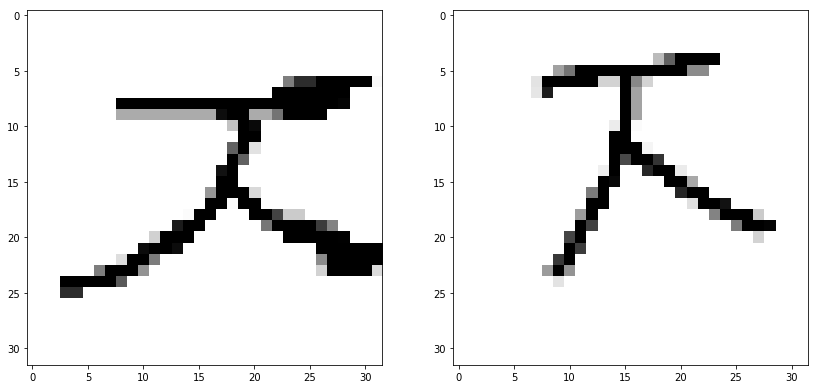

[[0.9687695]] 79


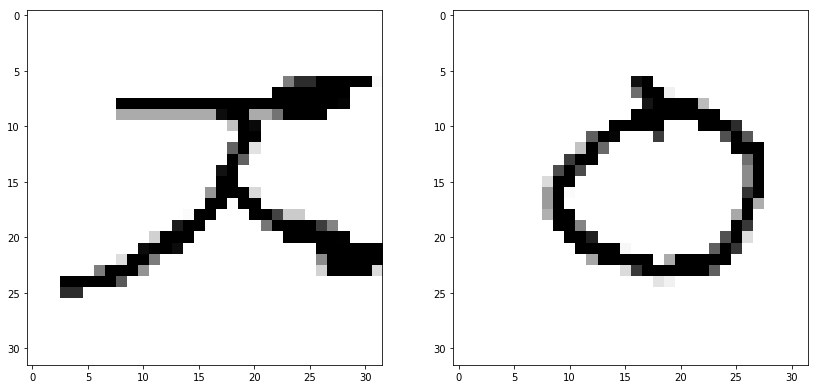

[[0.9687695]] 80


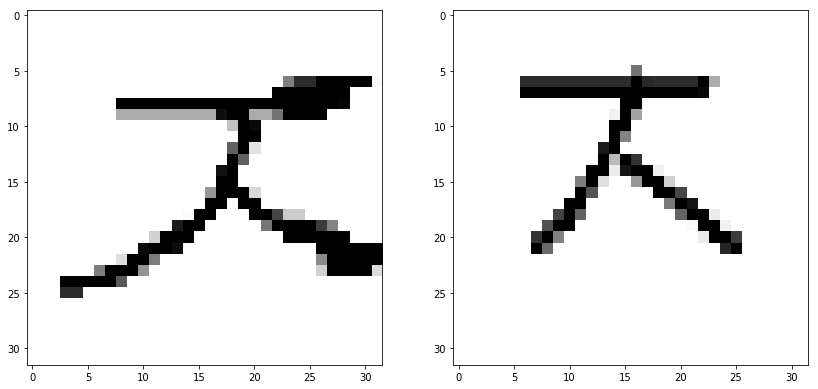

[[0.9687695]] 81


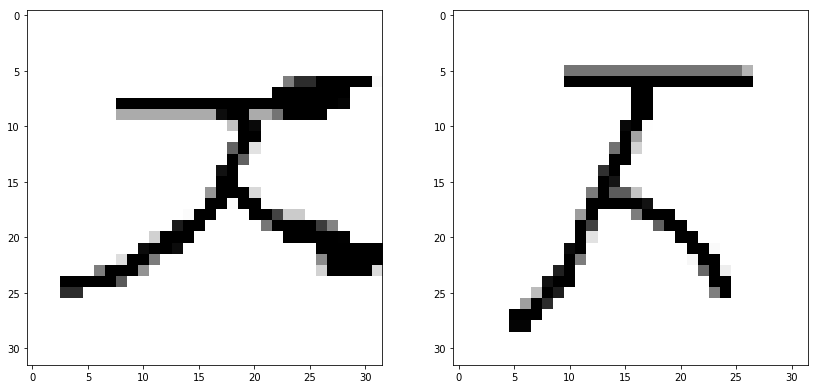

[[0.9687695]] 82


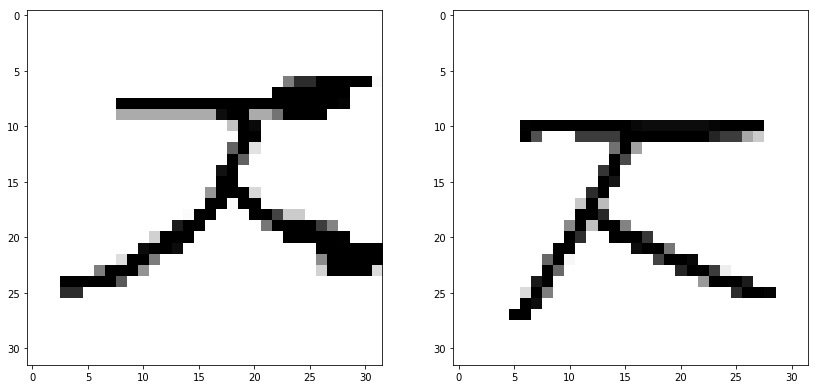

[[0.9687695]] 83


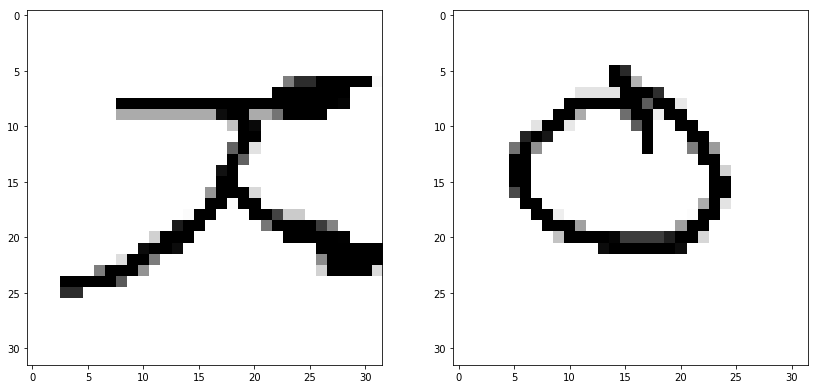

[[0.9687695]] 84


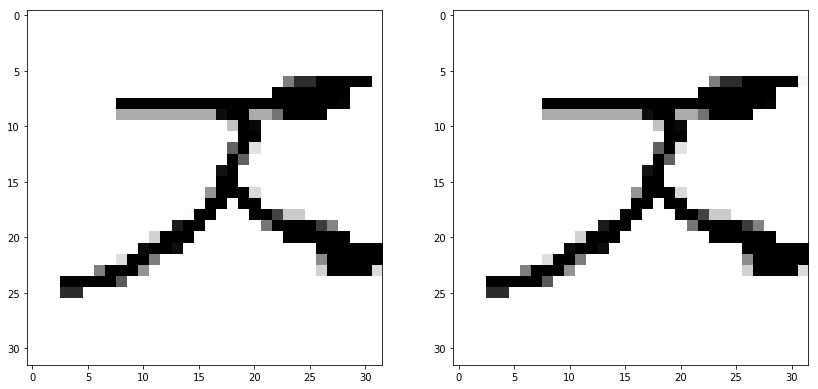

[[0.9687695]] 85


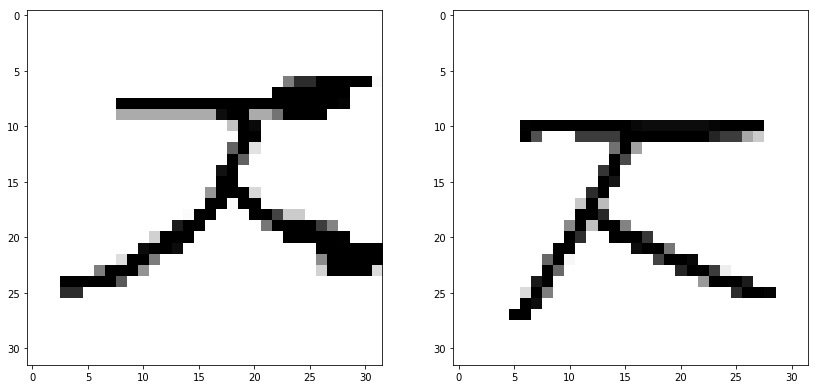

[[0.9687695]] 86


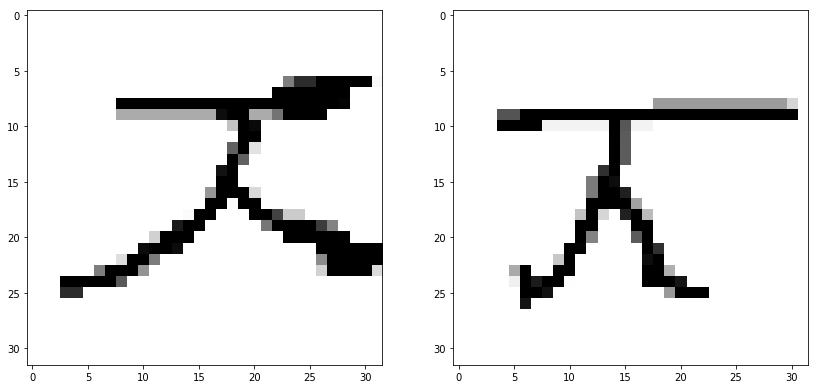

[[0.9687695]] 87


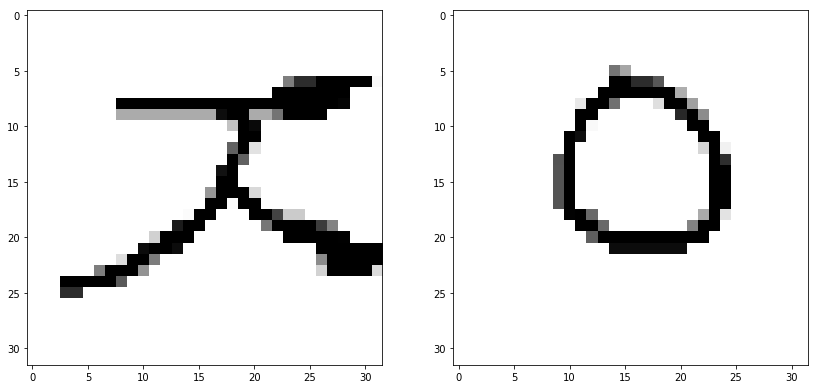

[[0.9687695]] 88


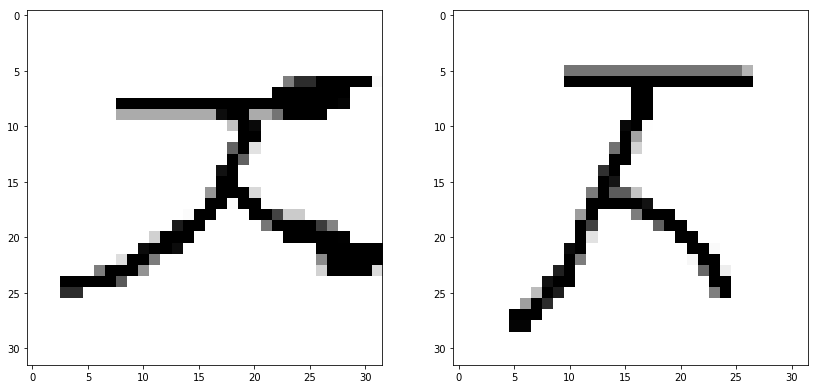

[[0.9687695]] 89


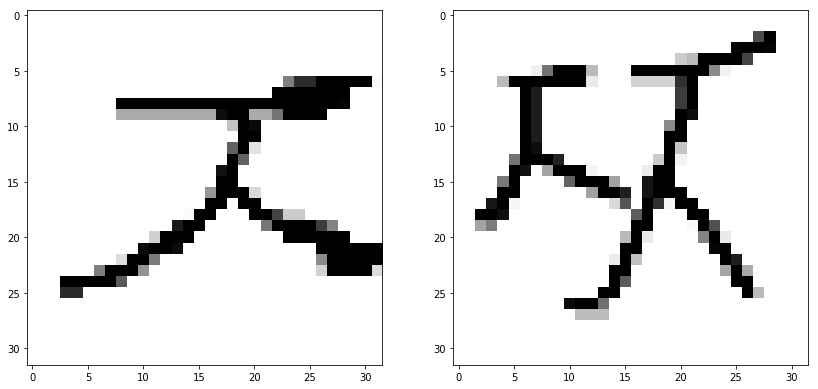

[[0.9687695]] 90


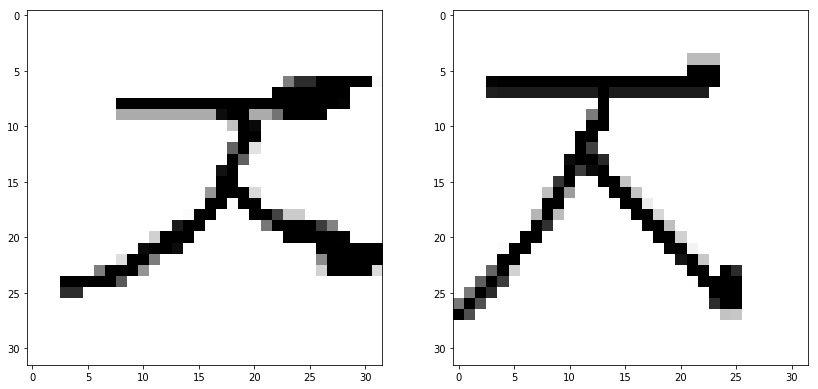

[[0.9687695]] 91


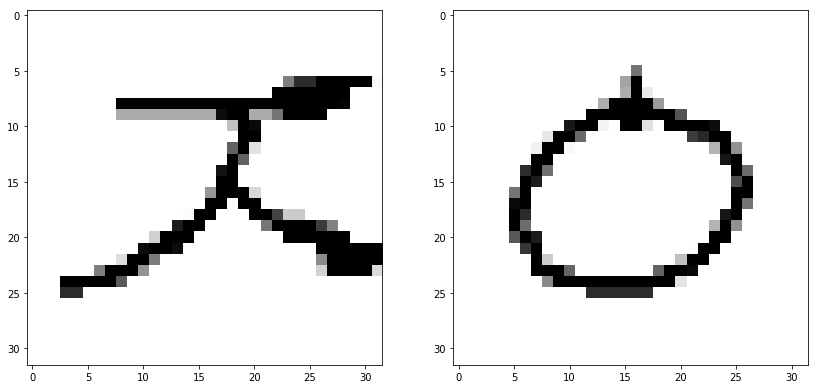

[[0.9687695]] 92


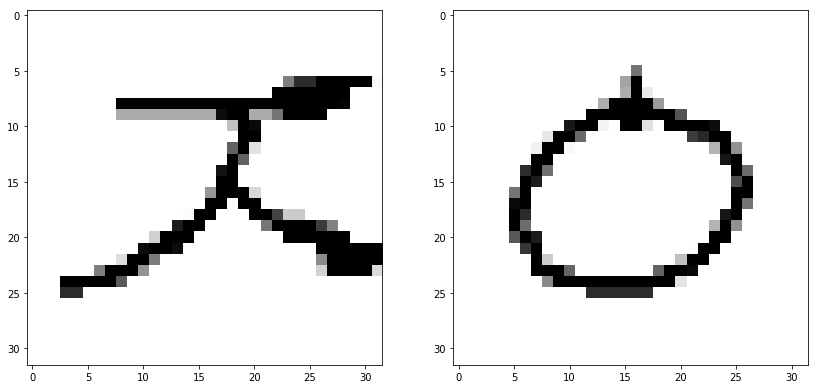

[[0.9687695]] 93


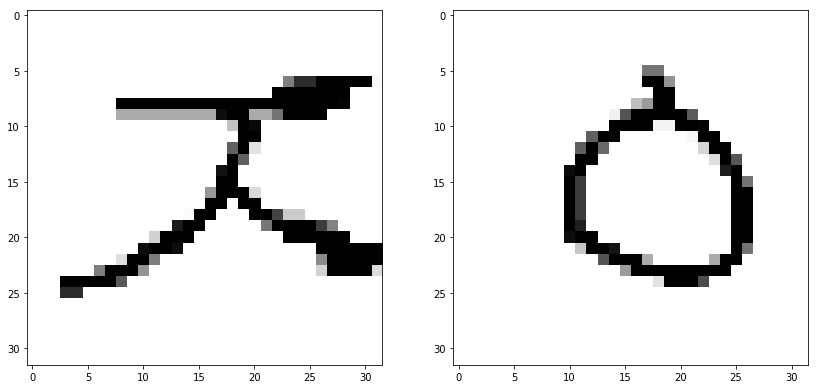

[[0.9687695]] 94


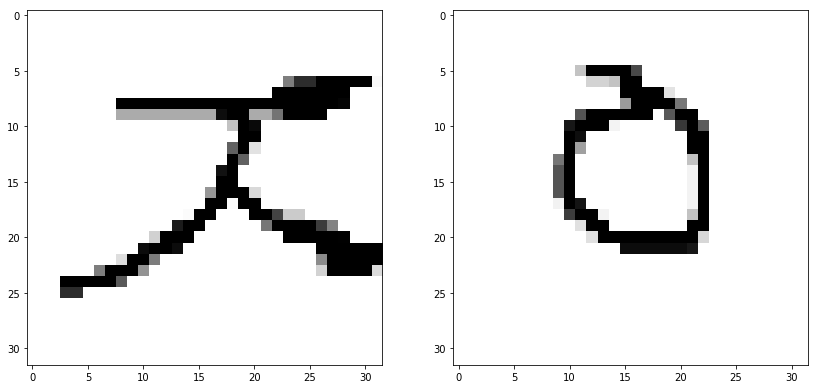

[[0.9687695]] 95


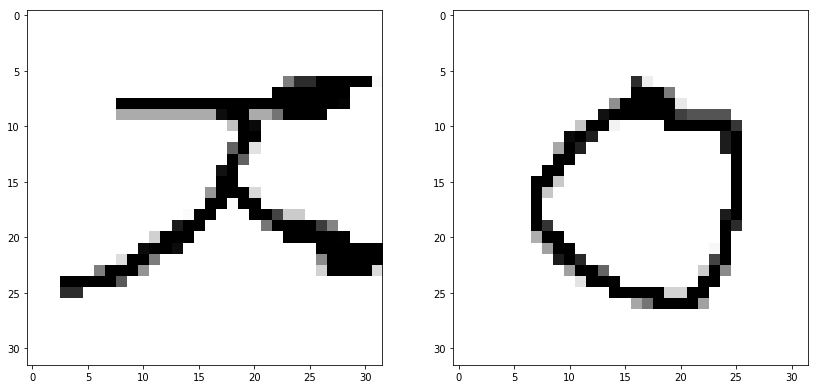

[[0.9687695]] 96


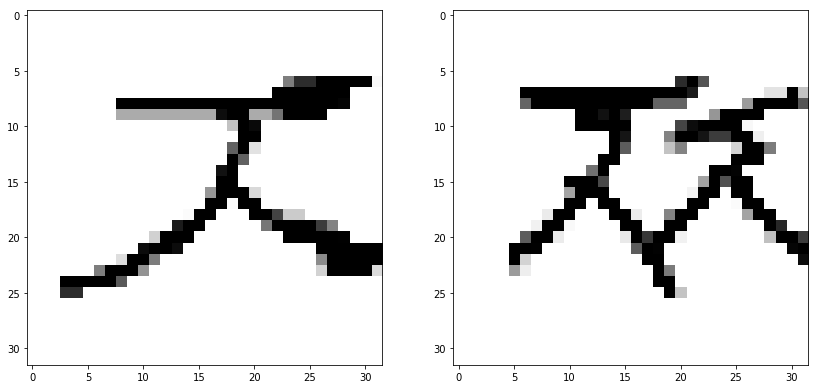

[[0.9687695]] 97


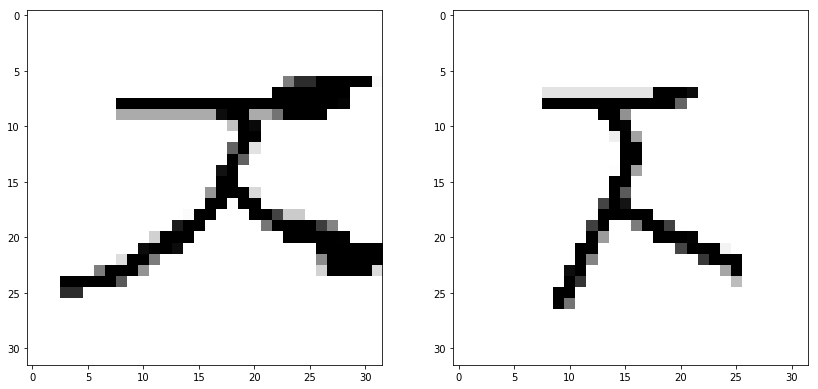

[[0.9687695]] 98


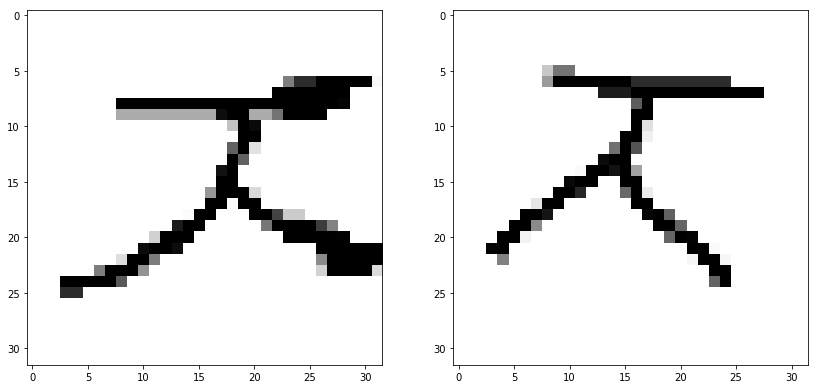

[[0.9687695]] 99


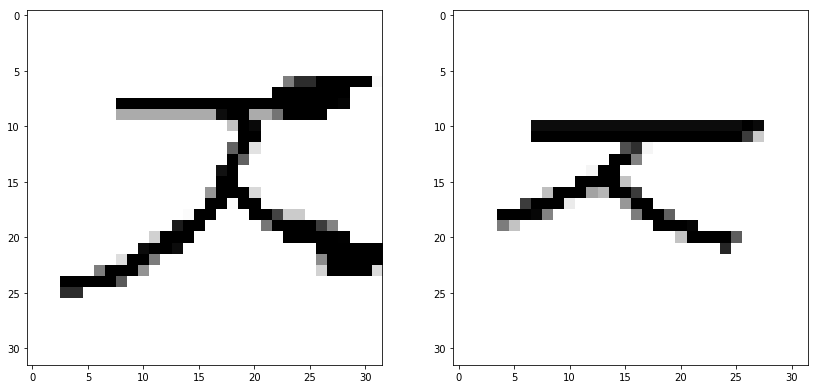

[[0.9687695]] 100


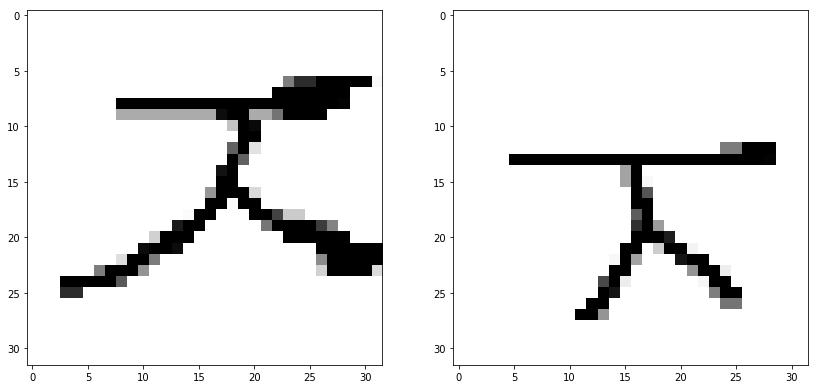

[[0.9687695]] 101


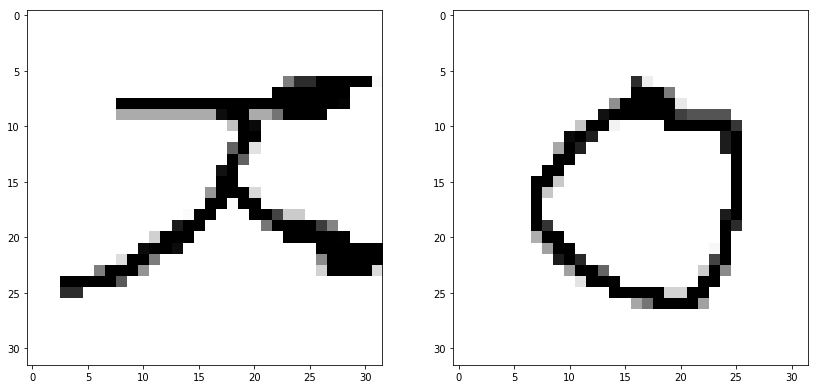

[[0.9687695]] 102


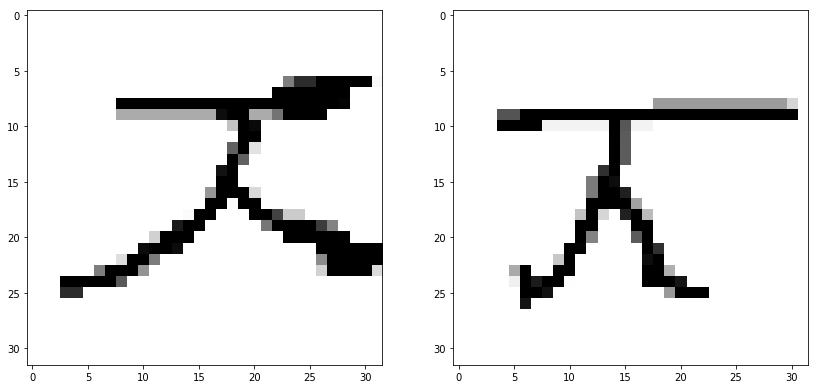

[[0.9687695]] 103


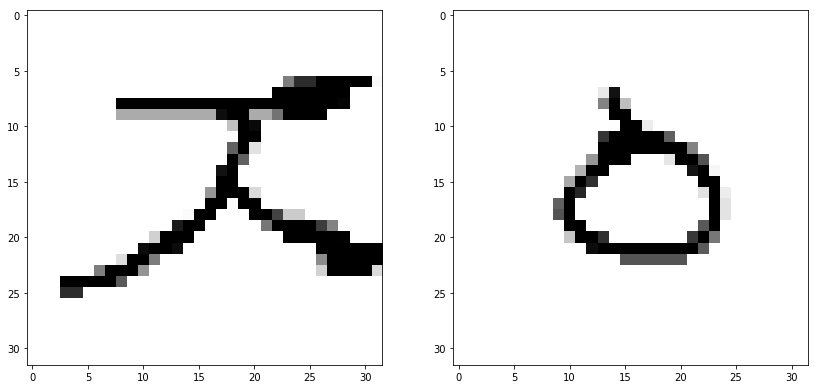

[[0.9687695]] 104


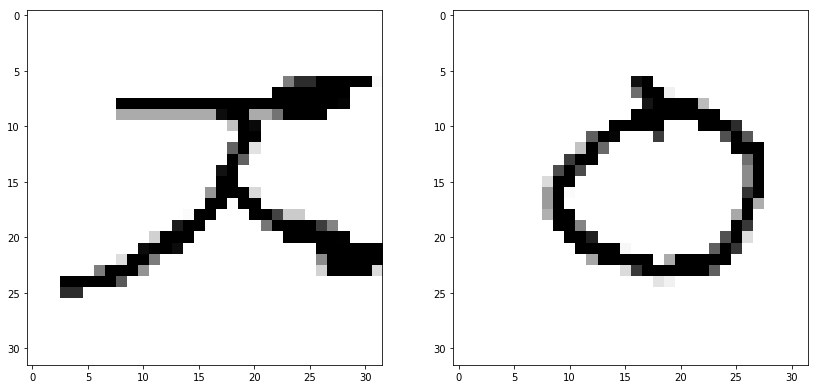

[[0.9687695]] 105


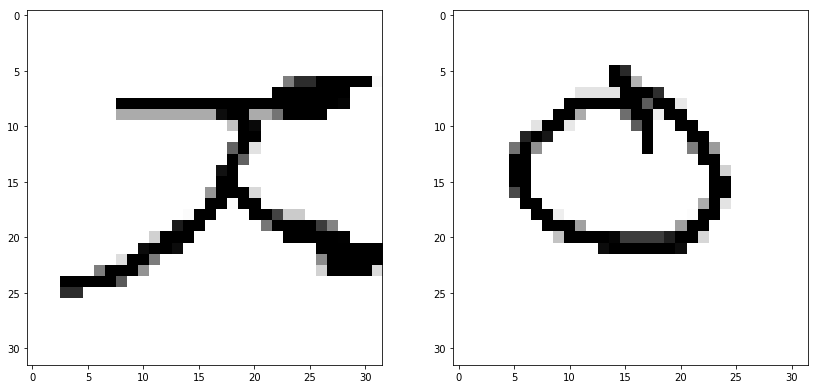

[[0.9687695]] 106


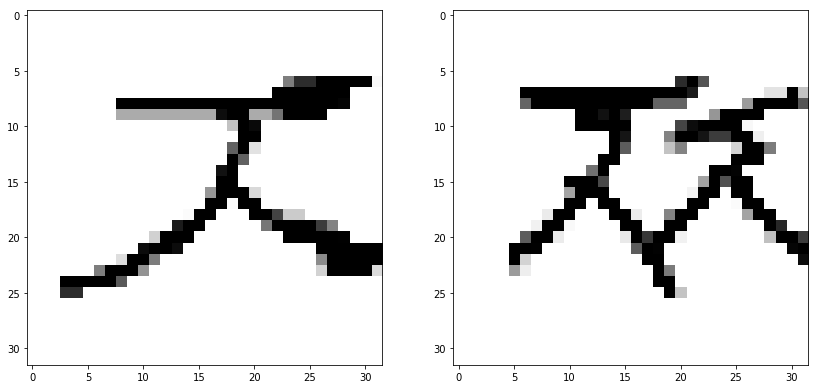

[[0.9687695]] 107


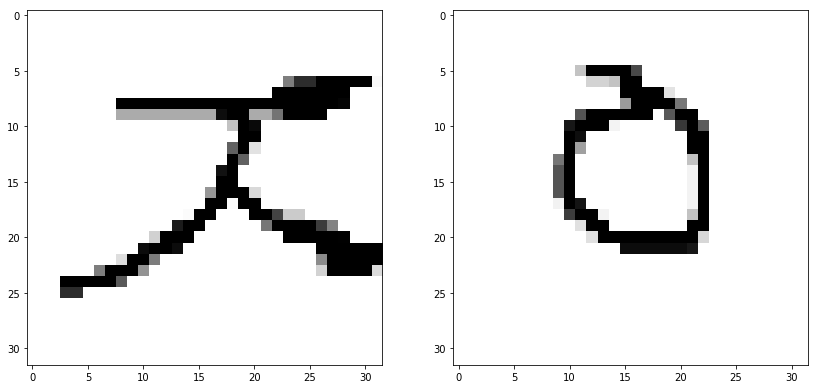

[[0.9687695]] 108


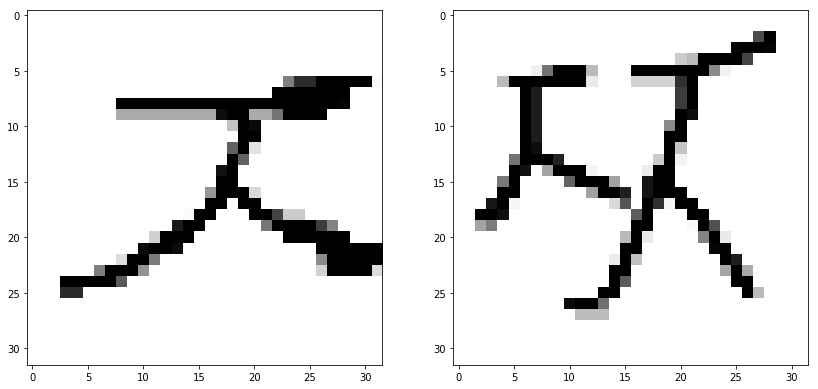

[[0.9687695]] 109


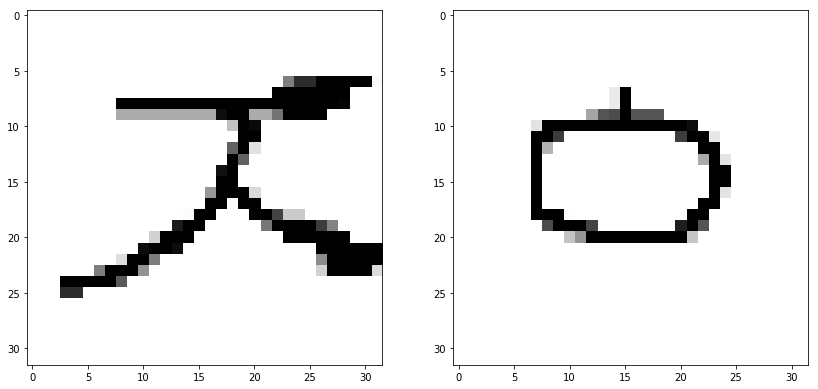

[[0.9687695]] 110


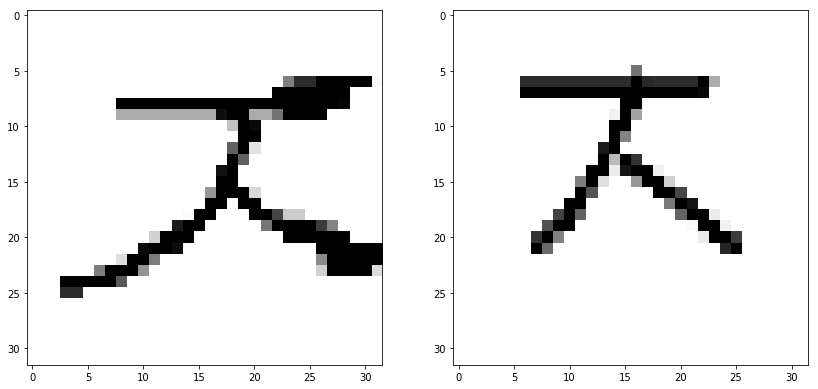

[[0.9687695]] 111


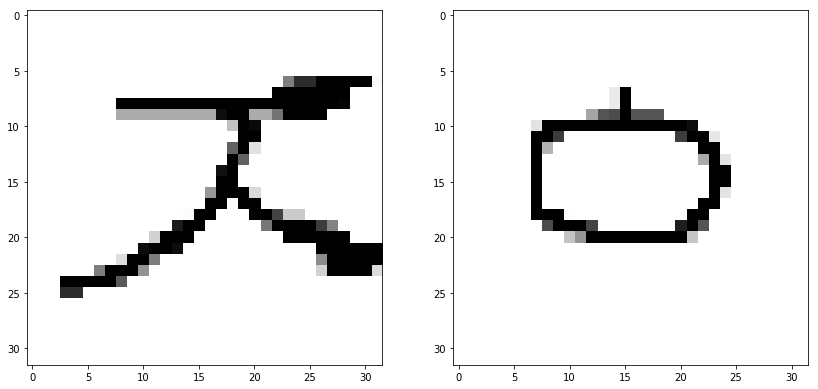

[[0.9687695]] 112


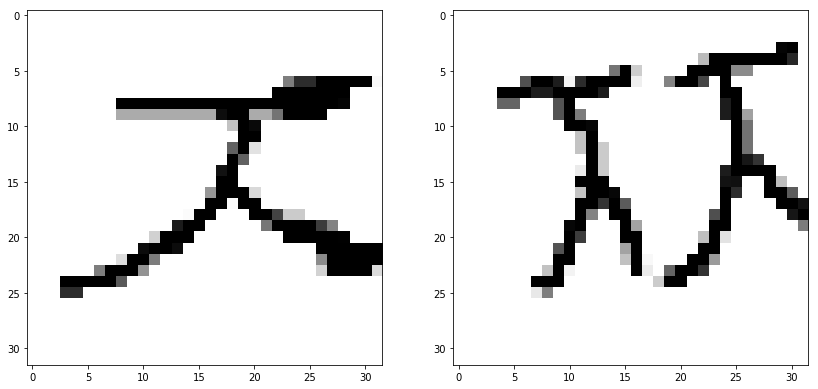

[[0.9687695]] 113


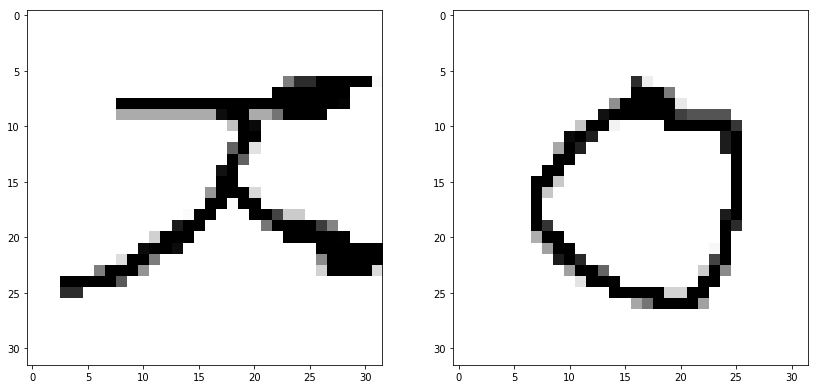

[[0.9687695]] 114


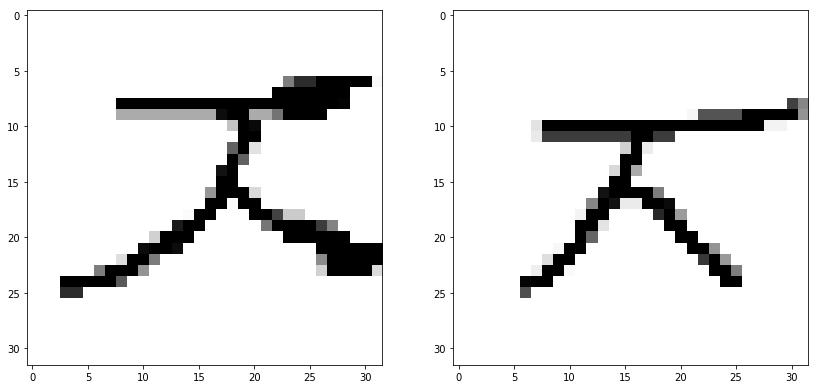

[[0.9687695]] 115


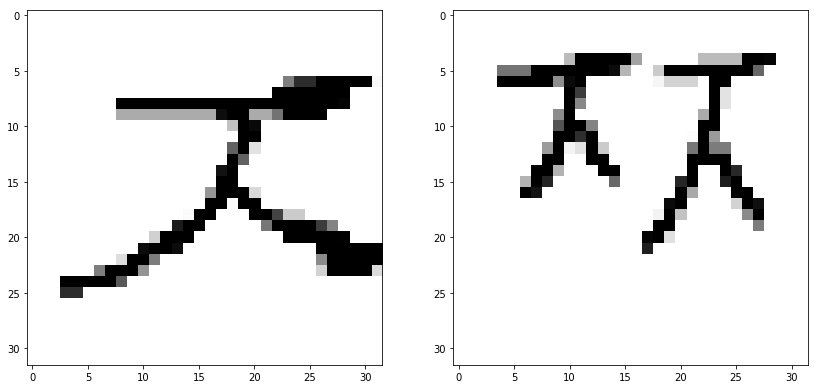

[[0.9687695]] 116


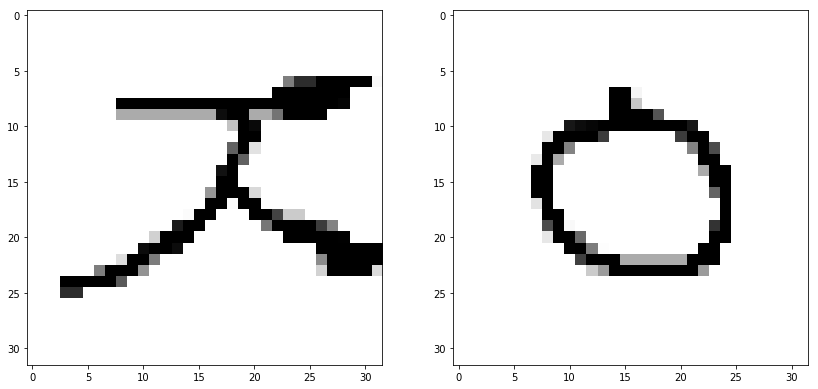

[[0.9687695]] 117


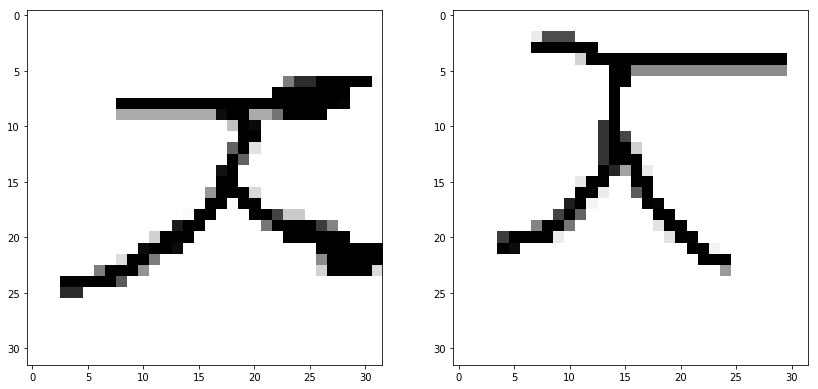

[[0.9687695]] 118


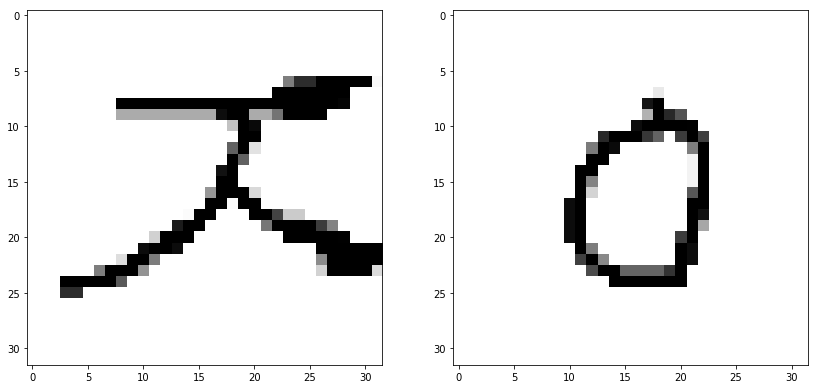

[[0.9687695]] 119


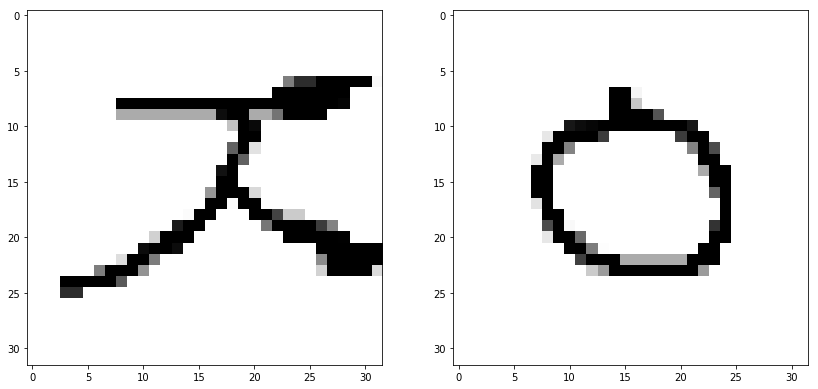

[[0.9687695]] 120


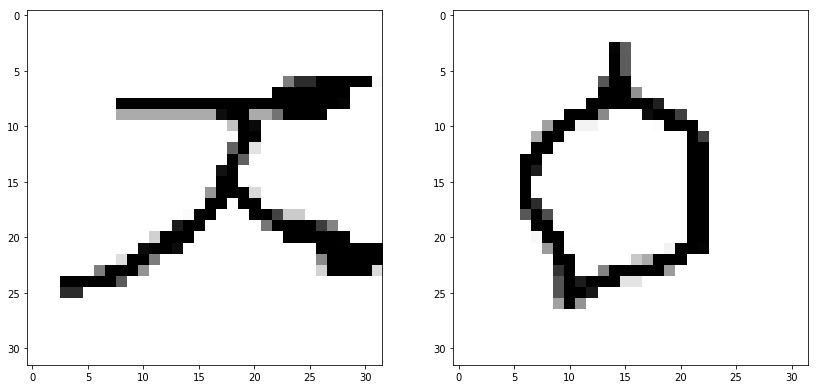

[[0.9687695]] 121


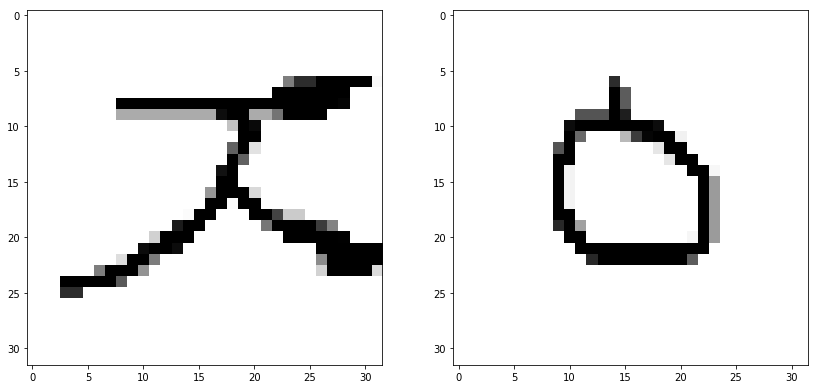

[[0.9687695]] 122


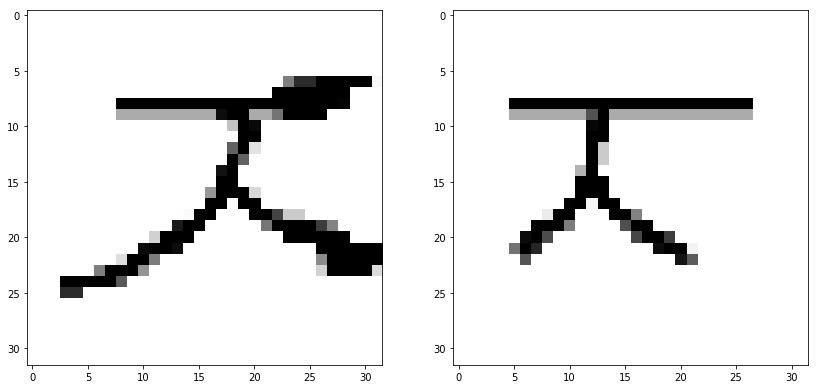

[[0.9687695]] 123


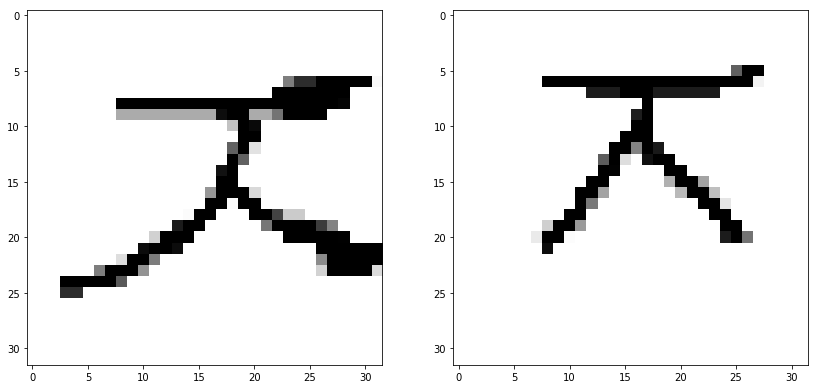

[[0.9687695]] 124


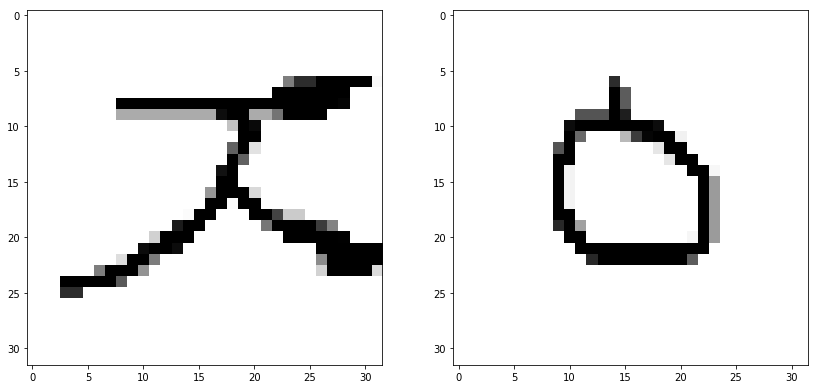

[[0.9687695]] 125


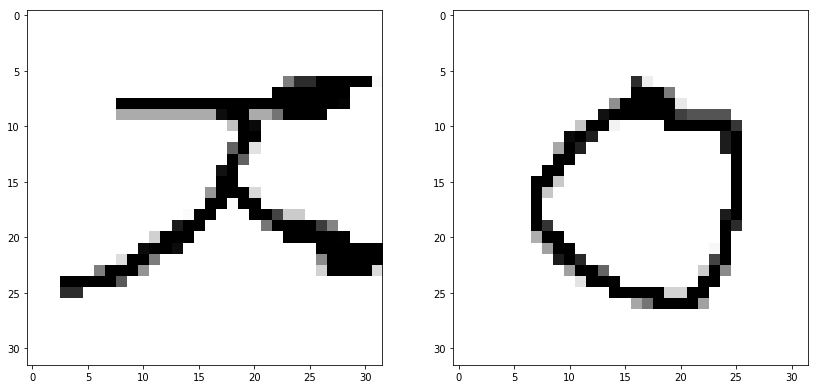

[[0.9687695]] 126


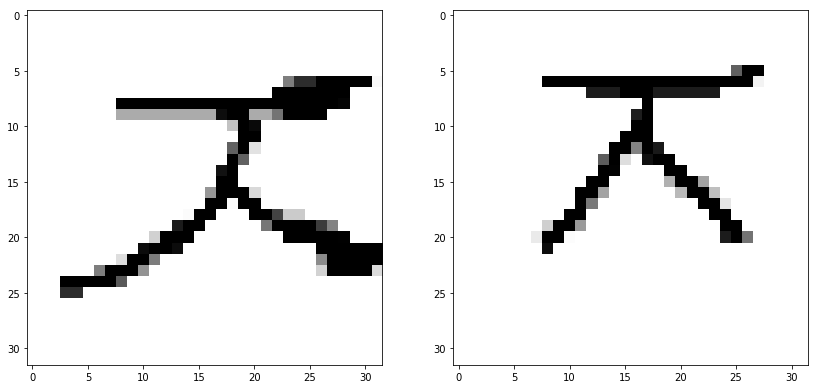

[[0.9687695]] 127


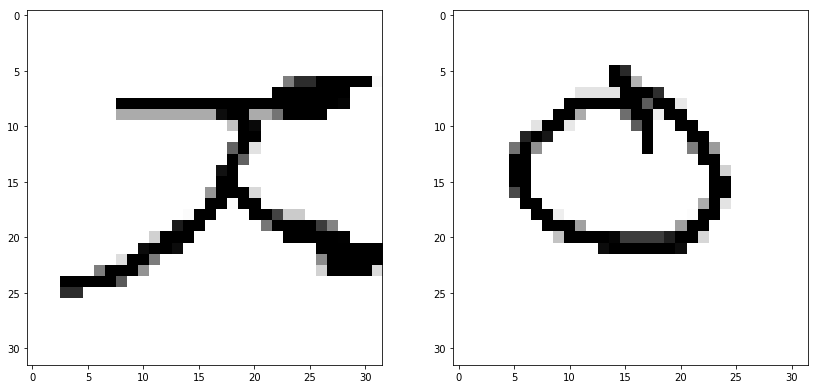

[[0.9687695]] 128


KeyboardInterrupt: 

In [96]:
test1 = xs0[0]
for i in range(1500):
    test2 = xs1[i]
    res = model.predict([t1,t2])
    if res > 0.5:
        print(res,i)
        ImgDisplay(test1 , test2)
    

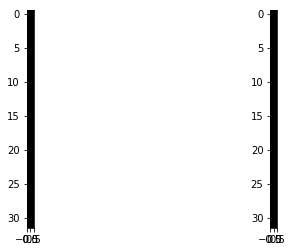

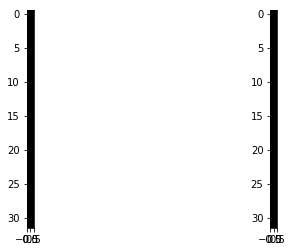

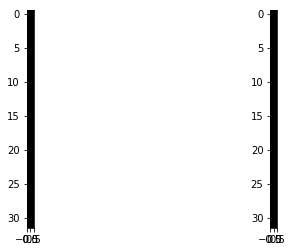

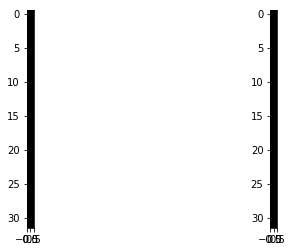

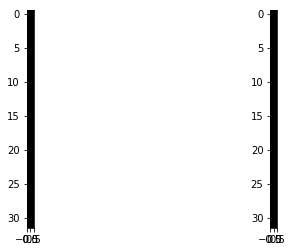

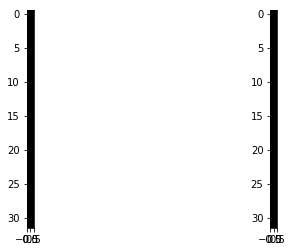

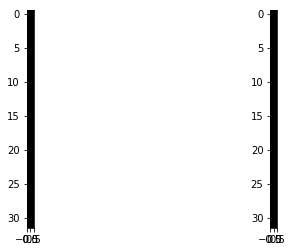

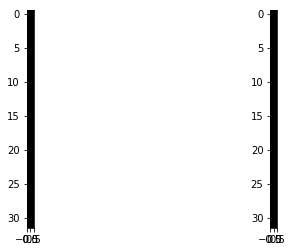

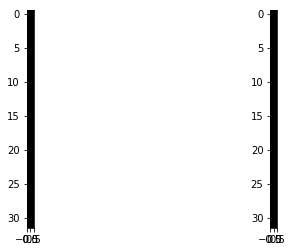

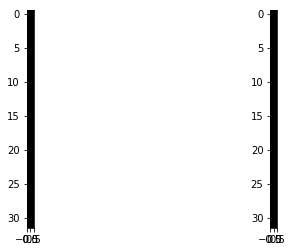

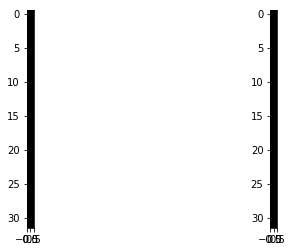

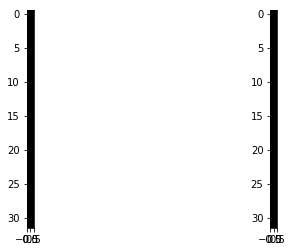

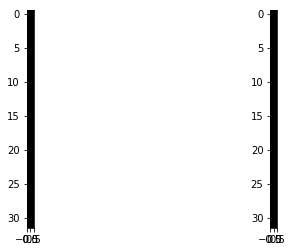

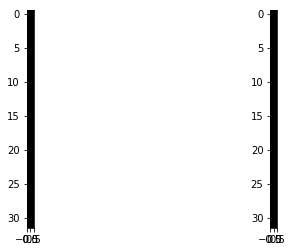

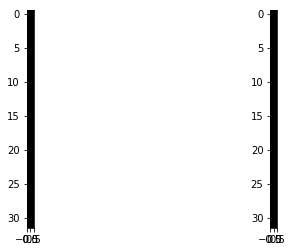

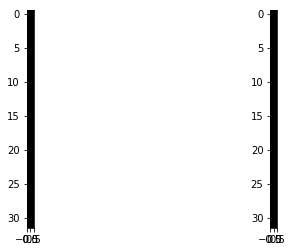

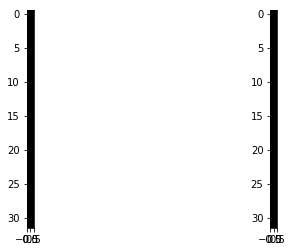

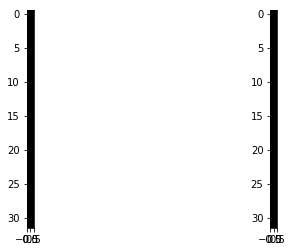

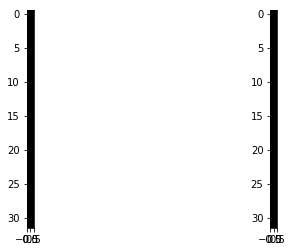

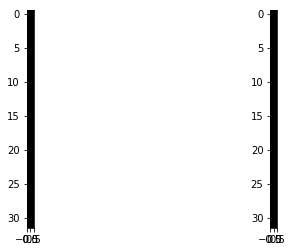

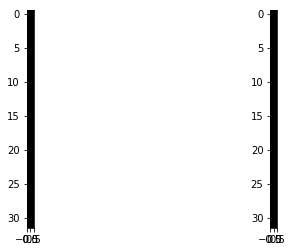

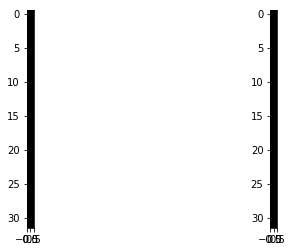

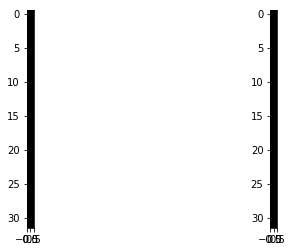

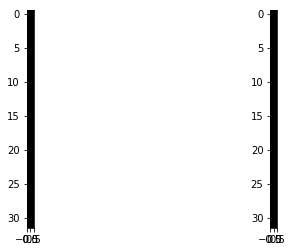

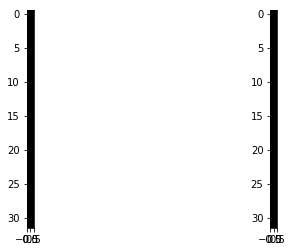

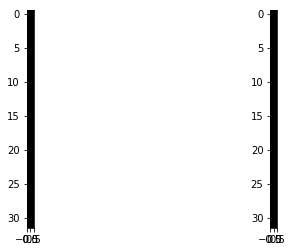

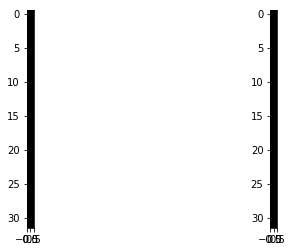

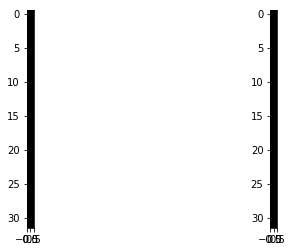

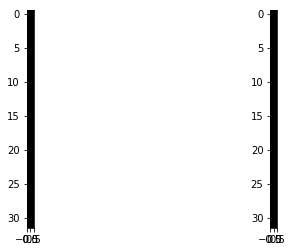

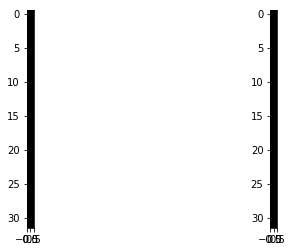

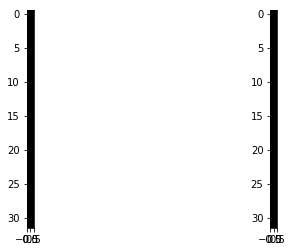

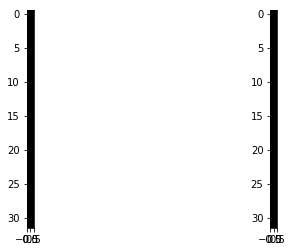

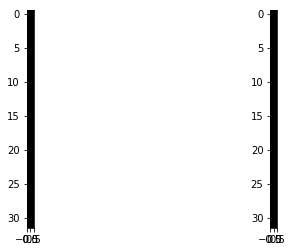

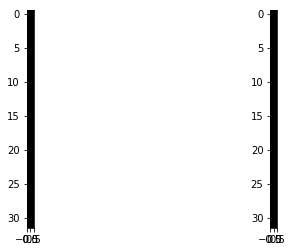

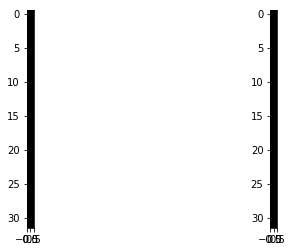

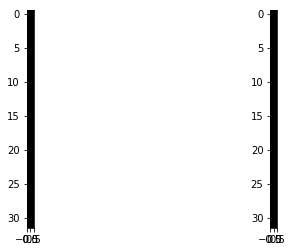

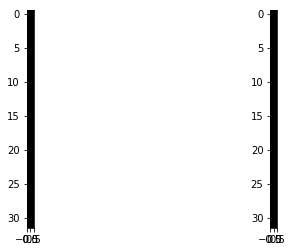

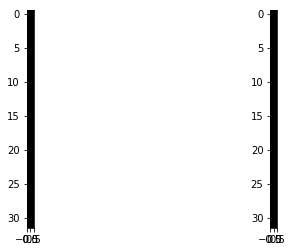

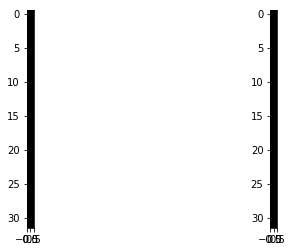

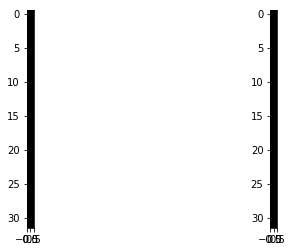

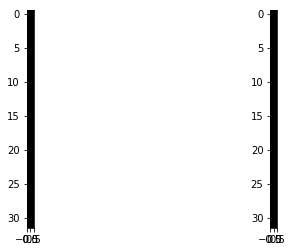

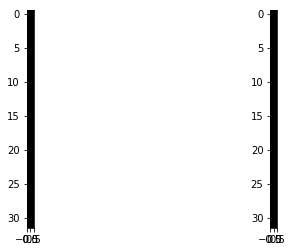

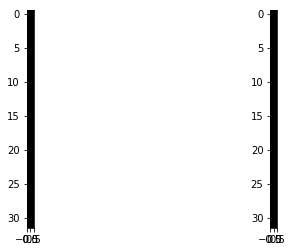

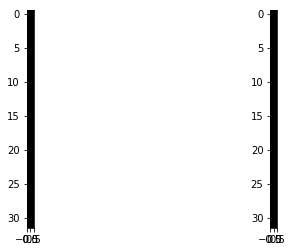

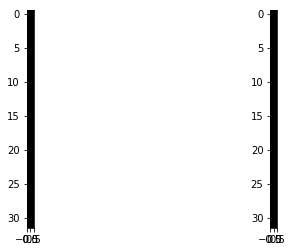

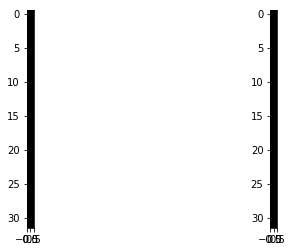

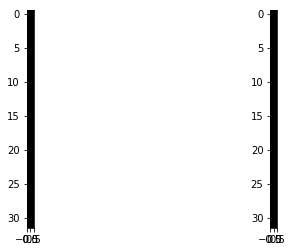

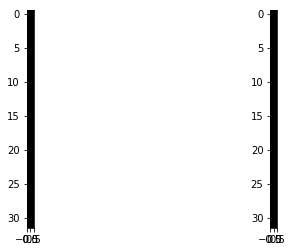

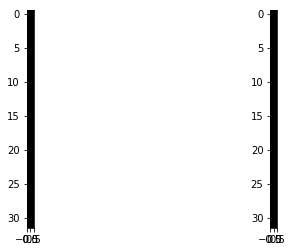

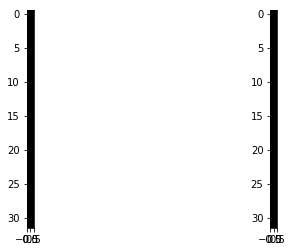

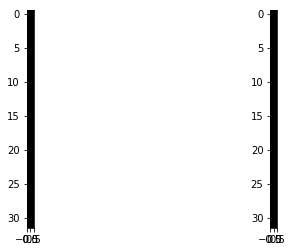

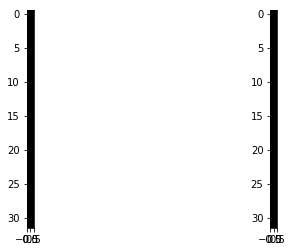

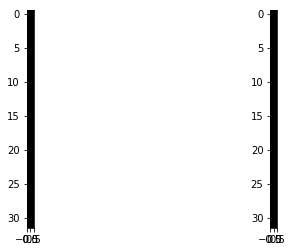

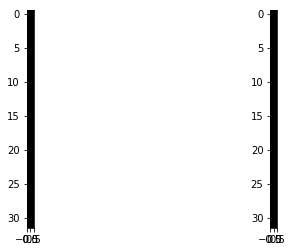

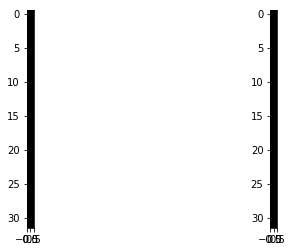

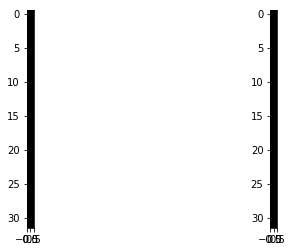

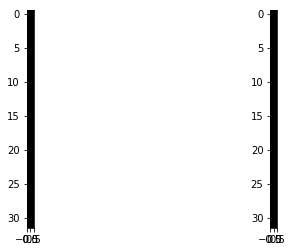

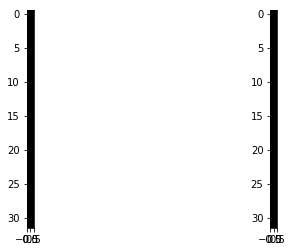

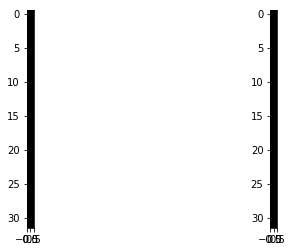

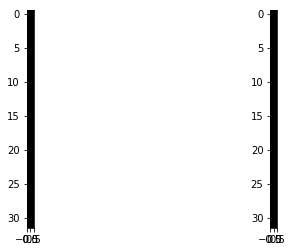

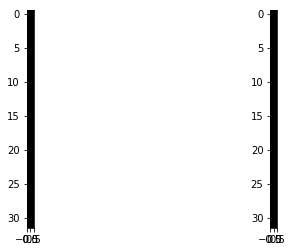

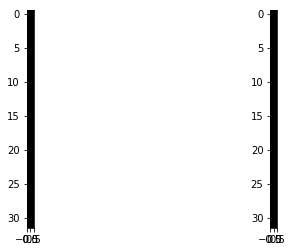

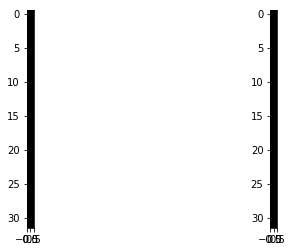

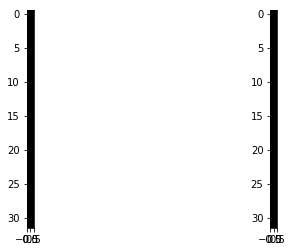

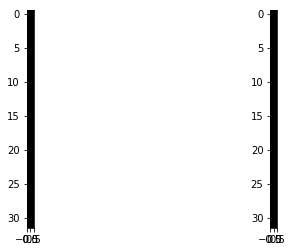

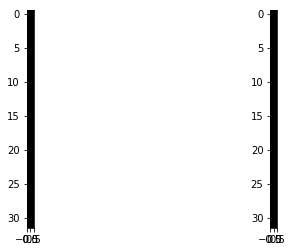

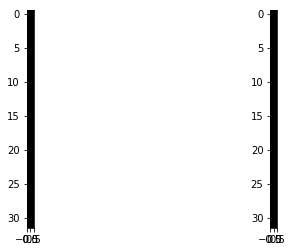

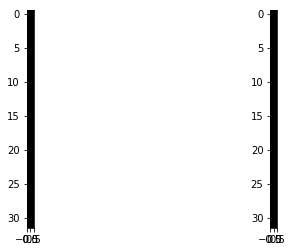

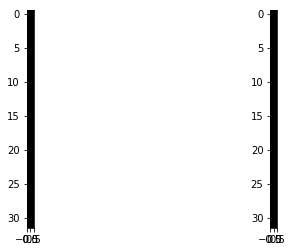

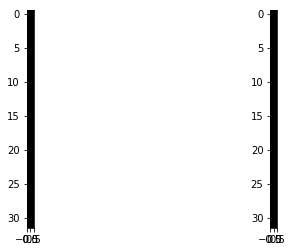

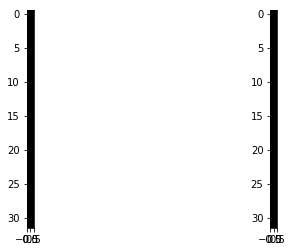

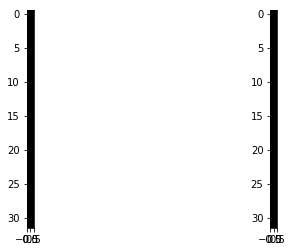

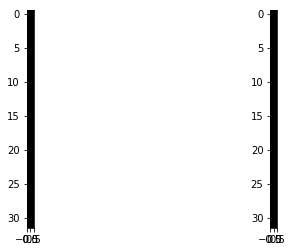

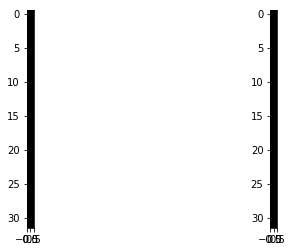

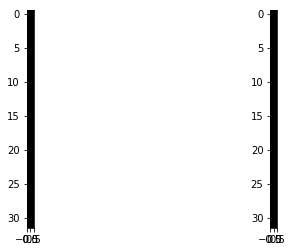

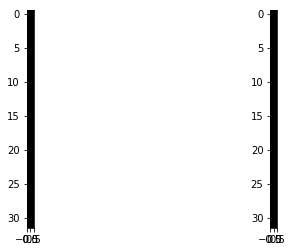

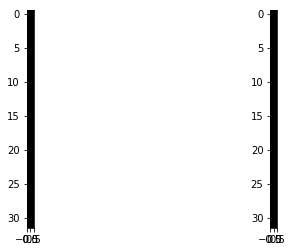

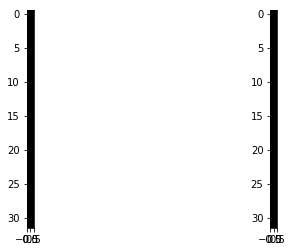

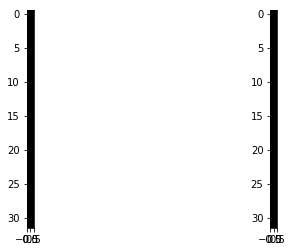

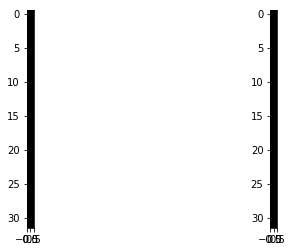

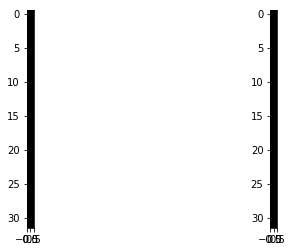

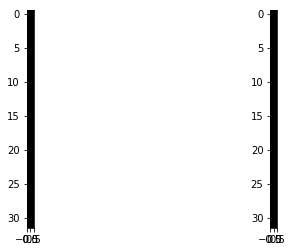

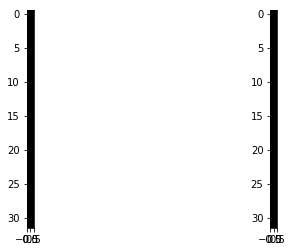

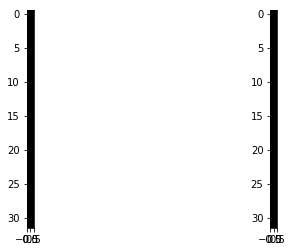

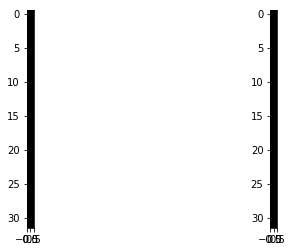

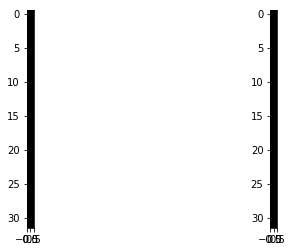

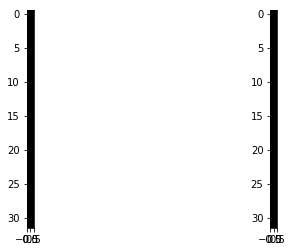

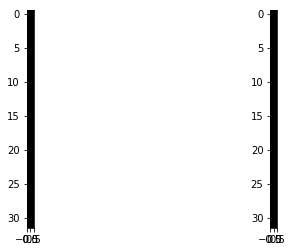

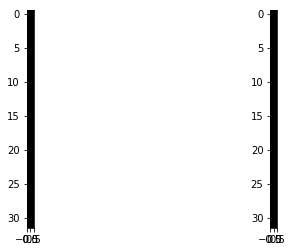

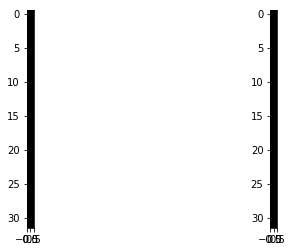

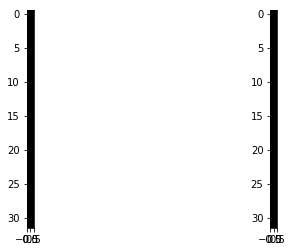

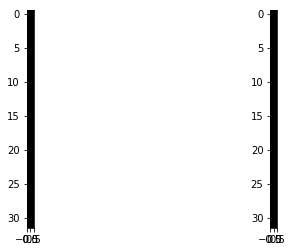

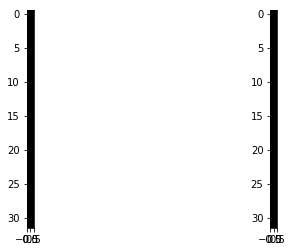

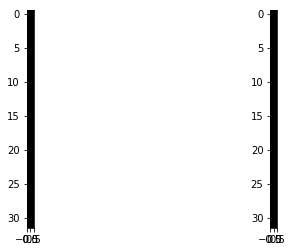

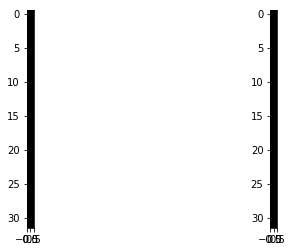

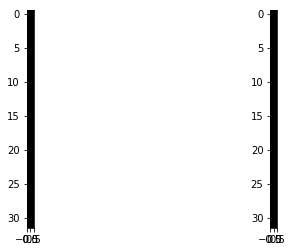

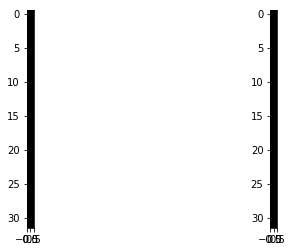

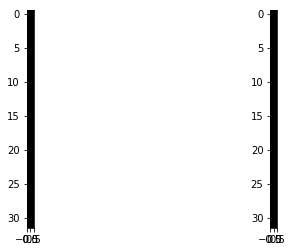

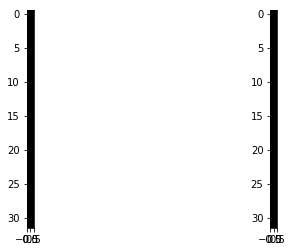

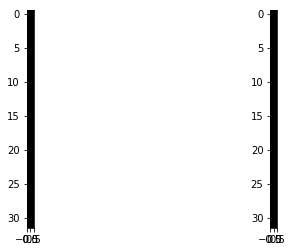

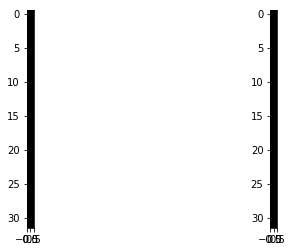

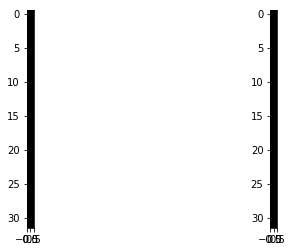

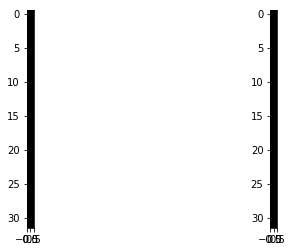

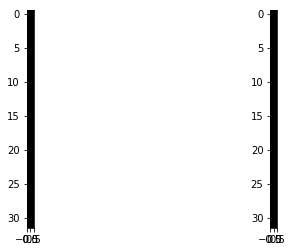

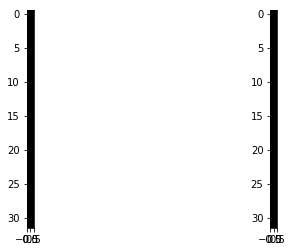

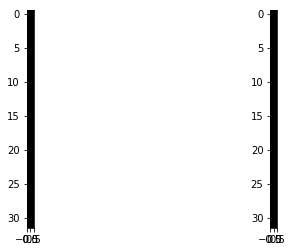

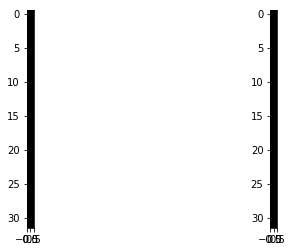

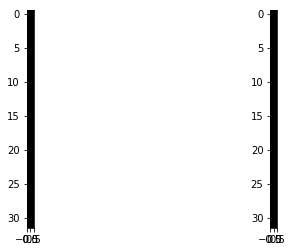

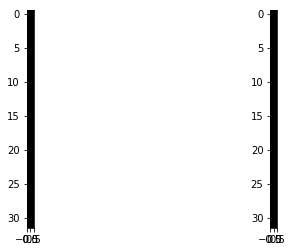

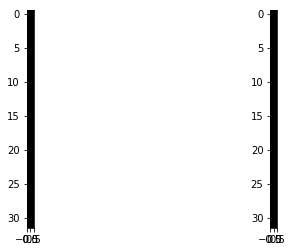

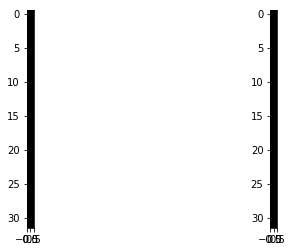

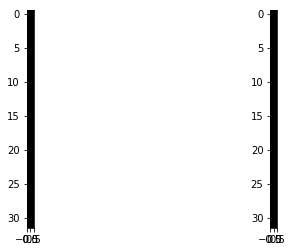

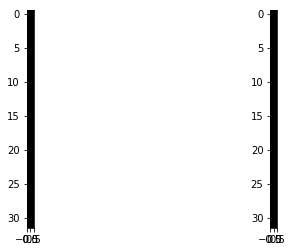

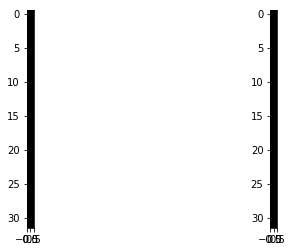

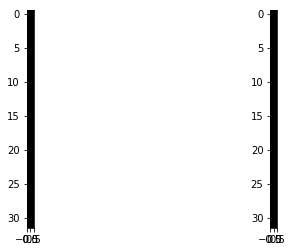

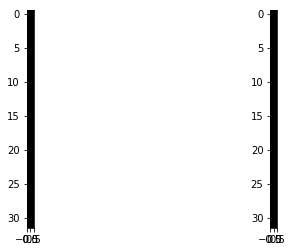

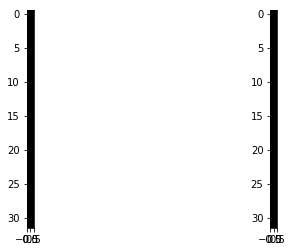

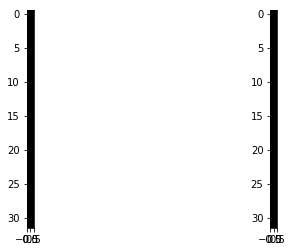

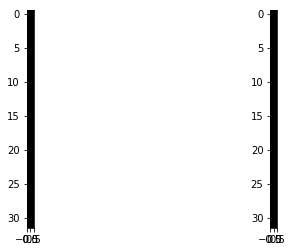

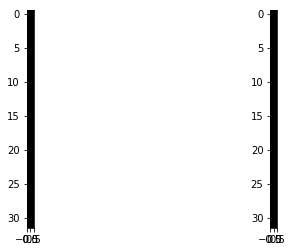

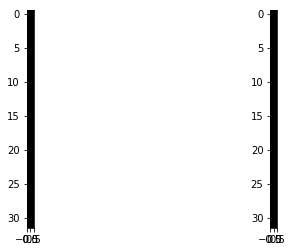

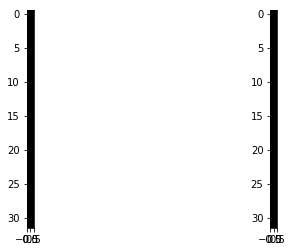

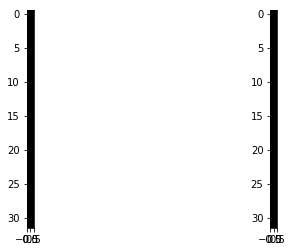

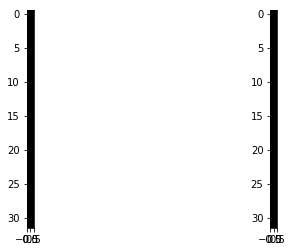

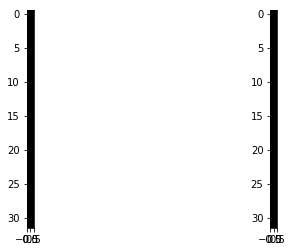

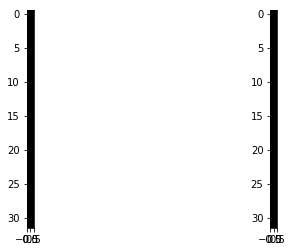

KeyboardInterrupt: 

In [98]:
for item in xs0:
    ImgDisplay(item[0] , item[1])
    